In [401]:
import pandas as pd
import numpy as np
import os
import pickle
from copy import deepcopy
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score
from scipy.stats import spearmanr
from data_loader import get_identifier
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


def read_labels(dataset_dir, file_path='/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/additional_lines_labels.xlsx'):
    """ Load labels from file """
    mapping = {'0': 0.,
               '0(0.5)': 1./3.,
               '0(1)': 1./3.,
               '0(1.5)': 2./3.,
               '0(2)': 1.,
               '1': 1.,
               '-': np.nan}

    for i in range(4):
        df = pd.read_excel(file_path, i)
        df.set_index('PATH', inplace=True)
        if dataset_dir in df.columns:
            label_df = df[dataset_dir]
            label_dict = {}
            for well_index, val in label_df.items():
                if well_index not in ['LINE', 'EX']:
                    well_index = tuple(well_index.split('_'))
                    if len(well_index) == 1:
                        well_index = well_index + ('5',)
                    label_val = mapping[str(val)]
                    if label_val == label_val:
                        label_dict[well_index] = label_val
            return label_dict
    return read_labels_from_fl(dataset_dir)


def read_labels_from_fl(dataset_dir, return_strategy='median'):
    """ Load labels based on fluorescence data """
    name_file = os.path.join(dataset_dir, 'names.pkl')
    classify_label_file = os.path.join(dataset_dir, 'classify_continuous_labels.pkl')
    if not os.path.exists(classify_label_file):
        print("No fluorescence labels for %s" % dataset_dir)
        return
    names = pickle.load(open(name_file, 'rb'))
    labels = pickle.load(open(classify_label_file, 'rb'))

    identifiers = {i: get_identifier(names[i]) for i in names}
    # Single experiment
    assert len(set([identifier[:2] for identifier in identifiers.values()])) == 1

    # For each well, get fluorescence labels after day 13
    well_labels = {}
    for i, identifier in identifiers.items():
        if int(identifier[2]) >= 13:
            well = identifier[-2:]
            if well not in well_labels:
                well_labels[well] = []
            if labels[i][1] > 0:
                well_labels[well].append(labels[i][0])

    label_dict = {}
    for well, well_label in well_labels.items():
        if len(well_label) == 0:
            continue
        diff_scores = [(l[1] + l[2] * 2 + l[3] * 3)/3 for l in well_label]
        if return_strategy == 'max':
            # Choose the label with the highest differentiation
            ii = np.argmax(diff_scores)
        elif return_strategy == 'median':
            # Choose median instead of max
            ii = np.argsort(diff_scores)[len(diff_scores) // 2]

        label_dict[well] = well_label[ii]
    return label_dict


def load_cla_pred_as_dict(path):
    """ Load prediction result from path """
    pred_file = os.path.join(path, 'cla.pkl')
    preds = pickle.load(open(pred_file, 'rb'))
    pred_dict = dict(zip([get_identifier(n) for n in preds['pred_names']], preds['cla_preds']))
    return pred_dict


def ensemble_multiple_cla_preds(pred_dicts):
    """ Combine multiple classification predictions """
    _pred_dict = {}
    assert all(sorted(pd.keys()) == sorted(pred_dicts[0].keys()) for pd in pred_dicts)
    for k in pred_dicts[0]:
        vs = [pd[k] for pd in pred_dicts]
        v = np.stack(vs, 0).mean(0)
        _pred_dict[k] = v
    return _pred_dict


def binarize_scores(pred_dict, cutoff=1, hard=False):
    """ Binarize multi-class predictions """
    _pd = {}
    for k, v in pred_dict.items():
        if isinstance(v, float) or isinstance(v, int):
            _v = v
        else:
            assert np.allclose(1, v.sum())
            _v = v[cutoff:].sum()
        if hard:
            _v = (_v > 0.5) * 1
        _pd[k] = _v
    return _pd

In [402]:
def evaluate_binary_metric(y_trues, y_preds, print_res=True):
    assert len(y_trues.shape) == 1
    assert y_trues.shape == y_preds.shape
    assert np.allclose(np.round(y_trues), y_trues)

    pos_rate = np.sum(y_trues) / len(y_trues)
    s1 = precision_score(y_trues, y_preds > 0.5)
    s2 = recall_score(y_trues, y_preds > 0.5)
    s3 = f1_score(y_trues, y_preds > 0.5)
    s4 = roc_auc_score(y_trues, y_preds)
    s5 = []
    for _ in range(100):
        inds = np.random.choice(np.arange(len(y_trues)), (len(y_trues),), replace=True)
        s5.append(roc_auc_score(y_trues[inds], y_preds[inds]))
    s5 = (np.mean(s5), np.std(s5))

    if print_res:
        print("N-samples: %d\tPos rate: %.3f\tPrec: %.3f\tRecall: %.3f\tF1: %.3f\tAUC: %.3f" % \
              (len(y_trues), pos_rate, s1, s2, s3, s4))
    return s1, s2, s3, s4, s5


def evaluate_confmat(y_trues, y_preds, soft=True):
    """ Evaluate 4-class confusion matrix """
    conf_mat = np.zeros((4, 4))
    assert y_trues.shape[1] == y_preds.shape[1] == 4
    assert y_trues.shape[0] == y_preds.shape[0]

    for y_true, y_pred in zip(y_trues, y_preds):
        label = np.argmax(y_true)
        if soft:
            conf_mat[label] += y_pred.reshape((4,))
        else:
            conf_mat[label, np.argmax(y_pred)] += 1
    return conf_mat


def report_series_accuracy(pred_dict,
                           label_dict,
                           start=1,
                           end=12,
                           exclude_ambiguous=False,
                           print_res=True):
    """ Calculate {day: binary metrics} curve """
    label_ks = sorted(label_dict.keys())
    if exclude_ambiguous:
        label_ks = [k for k in label_ks if np.round(label_dict[k]) == label_dict[k]]
        
    pred_val_df = pd.DataFrame({'label': [label_dict[k] for k in label_ks]})
    pred_val_df.index = label_ks

    curve = {}
    for day in np.arange(start, end+1):
        day_pd = {k[-2:]: v for k, v in pred_dict.items() if k[2] == str(day)}
        shared_keys = sorted(set(label_ks) & set(day_pd))

        if len(shared_keys) > 10:
            pred_val_df['D%d_pred' % day] = [day_pd[k] if k in day_pd else np.nan for k in label_ks]

            y_trues = np.stack([label_dict[k] for k in shared_keys], 0) > 0.5
            y_preds = np.stack([day_pd[k] for k in shared_keys], 0)
            if len(set(y_trues)) == 1:
                # one-class situation
                continue
            try:
                curve[int(day)] = evaluate_binary_metric(y_trues, y_preds, print_res=print_res)
            except Exception as e:
                print("ERROR calculating metrics %s" % e)
            
    return curve, pred_val_df

In [403]:
def combine_multi_line_preds(pred_val_dfs, 
                             label_cutoff=0.5,
                             start=4,
                             end=10,
                             exclude_ambiguous=False):
    combined_df = []
    all_columns = set().union(*[pred_val_df.columns for pred_val_df in pred_val_dfs.values()])
    for k, pred_val_df in pred_val_dfs.items():
        pred_val_df = deepcopy(pred_val_df)
        pred_val_df.index = [(k, p) for p in pred_val_df.index]
        for c in all_columns:
            if not c in pred_val_df:
                pred_val_df[c] = [np.nan for _ in range(pred_val_df.shape[0])]
        combined_df.append(pred_val_df)

    combined_df = pd.concat(combined_df)
    curve = {}
    for day in np.arange(start, end+1):
        label = np.array(combined_df['label']).flatten()
        pred = np.array(combined_df['D%d_pred' % day]).flatten()

        if exclude_ambiguous:
            valid_inds = np.where((label == np.round(label)) * (pred == pred))[0]
        else:
            valid_inds = np.where(pred == pred)[0]

        label_ar = (label[valid_inds] > label_cutoff) * 1
        res = evaluate_binary_metric(label_ar, pred[valid_inds])
        curve[day] = res
    return curve, combined_df

In [404]:
# SAVE_ROOT = 'C://Users//zhenq//Dropbox//DiffPred_figs'

color_mapping = {
    'Validation: 3R': matplotlib.cm.tab20(0),
    'Test: 3R': matplotlib.cm.tab20(18),
    'Test: TNNI': matplotlib.cm.tab20(2),

    '12 well: 3R-839-975': matplotlib.cm.tab20(0),
    # '12 well: 3R': matplotlib.cm.tab20(0),
    '24 well: 3R-839-975': matplotlib.cm.tab20(1),
    # '24 well: 3R': matplotlib.cm.tab20(1),
    'Diff. Media: 3R-839': matplotlib.cm.tab20(2),
    # 'Diff. Media: 3R': matplotlib.cm.tab20(2),
    'Diff. Instrument: 3R': matplotlib.cm.tab20(3),
    
    'Test: 477': matplotlib.cm.tab20(6),
    'Test: 202': matplotlib.cm.tab20(7),
    'Test: 20': matplotlib.cm.tab20(8),
    'Test: 100': matplotlib.cm.tab20(9),
    'Test: 142': matplotlib.cm.tab20(10),
    'Test: 273': matplotlib.cm.tab20(11),
    'Test: 839': matplotlib.cm.tab20(4),
    'Test: 480': matplotlib.cm.tab20(2),
    'Test: 854': matplotlib.cm.tab20(3),
    'Test: 975': matplotlib.cm.tab20(5),
    
    'Test: Combined': (0.9, 0.9, 0.9, 1.0),
    'Prospective: 3R': matplotlib.cm.tab20(0),
}

marker_mapping = {
    '12-well: 839': 'v',
    '12-well: 975': '^',
}

In [405]:
def plot_as_well(pred_val_df, 
                 well='A1', 
                 well_size=14,
                 use_cols=['label', 'D4_pred', 'D5_pred', 'D6_pred', 'D8_pred', 'D10_pred']):

    # z-score predictions
    # for col in use_cols:
    #     if 'pred' in col:
    #         pred_val_df[col] = (pred_val_df[col] - pred_val_df[col].mean())/pred_val_df[col].std()

    well_rows = [r for r in pred_val_df.index if r[0] == well]
    sub_df = pred_val_df.loc[well_rows]

    mats = {}
    for col in use_cols:
        mat = np.ones((well_size, well_size)) * -10
        for row, v in zip(sub_df.index, list(sub_df[col])):
            position_code = int(row[1]) - 1
            i, j = position_code // well_size, position_code % well_size
            mat[i, j] = np.clip(np.log(v / (1 - v + 1e-5)), -2, 1.5)
        mats[col] = mat

    cm = matplotlib.cm.viridis
    cm.set_under('w')

    plt.figure(figsize=(3*len(use_cols), 3), frameon=False)
    for i, col in enumerate(use_cols):
        plt.subplot(1, len(use_cols), i+1)
        vmin = -2
        vmax = 1.5
        plt.imshow(mats[col], vmin=vmin, vmax=vmax, cmap=cm)
        plt.axis('off')
    return mats


def plot_roc_auc_curves(roc_auc_curves, day_range=(1, 10), plot_median=False, plot_kwargs={}):
    for line, curve in roc_auc_curves.items():
        x = [_x for _x in sorted(curve.keys()) if day_range[0] <= _x <= day_range[1]]
        aucs = [curve[_x][3] for _x in x]
        auc_errs = [curve[_x][4][1] for _x in x] if len(curve[x[0]]) > 4 else None
        # Line-specific plotting settings
        line_kwargs = {}
        if line in color_mapping:
            line_kwargs['color'] = color_mapping[line]
        line_kwargs['marker'] = 'o'
        if line in marker_mapping:
            line_kwargs['marker'] = marker_mapping[line]
        plt.errorbar(x, aucs, yerr=auc_errs, label=line, **plot_kwargs, **line_kwargs)

    if plot_median:
        x = sorted(set().union(*[curve.keys() for curve in roc_auc_curves.values()]))
        median_line = [np.nanmedian([curve[_x][3] if _x in curve else np.nan for curve in roc_auc_curves.values()]) for _x in x]
        plt.plot(x, median_line, '*-', color='k', label='Median')

    plt.xlabel("Input Phase Contrast Day")
    plt.ylabel("ROC-AUC")


def plot_roc_auc_box(roc_auc_curves, day_range=(1, 10)):
    scores_by_day = []
    for line, curve in roc_auc_curves.items():
        x = [_x for _x in sorted(curve.keys()) if day_range[0] <= _x <= day_range[1]]
        for _x in x:
            scores_by_day.append((_x, curve[_x][3]))

    scores_by_day = pd.DataFrame(np.array(scores_by_day), columns=['day', 'score'])
    sns.boxplot(x='day',
                y='score',
                data=scores_by_day,
                color=(0.9, 0.9, 0.9, 1.0))
    plt.ylim(0.4, 1.01)
    plt.xlabel("Input Phase Contrast Day")
    plt.ylabel("ROC-AUC")

<br/><br/><br/><br/>
### Classification perf: original validation/test ###

In [207]:
curves = {}
pred_val_dfs = {}
pred_file_names = ['psp-valid-pred-to-15']#, 'psp-valid-pred-to-17', 'psp-valid-pred-to-18']

In [208]:
### Validation ###
line_name = 'Validation: 3R'
line_path = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex15_full/0-to-0'

label_dict = read_labels_from_fl(line_path, return_strategy='median')
pred_dicts = [load_cla_pred_as_dict(line_path.replace('0-to-0', pred_file_name)) for pred_file_name in pred_file_names if os.path.exists(line_path.replace('0-to-0', pred_file_name))]
ens_pd = ensemble_multiple_cla_preds(pred_dicts)

binary_label_dict = binarize_scores(label_dict, cutoff=1)
binary_pred_dicts = [binarize_scores(pred_dict, cutoff=1) for pred_dict in pred_dicts]
binary_ens_pd = binarize_scores(ens_pd, cutoff=1)
auc_curve, pred_val_df = report_series_accuracy(binary_ens_pd, binary_label_dict, start=2, end=10, print_res=False)
curves[line_name] = auc_curve
pred_val_dfs[line_name] = pred_val_df

In [209]:
### Test ###
line_paths = {
    'Test: 3R': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex7_full/0-to-0',
    'Test: TNNI': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line3_TNNI/ex4_full/0-to-0',
}
for line_name, line_path in line_paths.items():
    label_dict = read_labels_from_fl(line_path, return_strategy='median')
    pred_dicts = [load_cla_pred_as_dict(line_path.replace('0-to-0', pred_file_name)) for pred_file_name in pred_file_names if os.path.exists(line_path.replace('0-to-0', pred_file_name))]
    ens_pd = ensemble_multiple_cla_preds(pred_dicts)
    
    binary_label_dict = binarize_scores(label_dict, cutoff=2)
    binary_pred_dicts = [binarize_scores(pred_dict, cutoff=2) for pred_dict in pred_dicts]
    binary_ens_pd = binarize_scores(ens_pd, cutoff=2)
    auc_curve, pred_val_df = report_series_accuracy(binary_ens_pd, binary_label_dict, start=2, end=10, print_res=False)
    curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

/home/users/zqwu/miniconda3/envs/DiffPred/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 640x480 with 0 Axes>

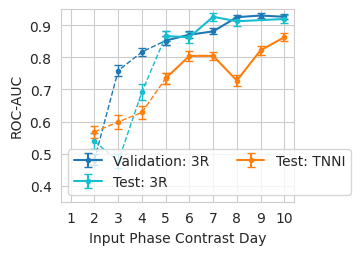

In [210]:
plt.clf()
plt.figure(figsize=(3, 2.5))
plot_kwargs = {'markersize': 3., 'linewidth': 1.5, 'capsize': 3.0, 'fmt': '-'}
plot_roc_auc_curves(curves, day_range=(5, 10), plot_median=False, plot_kwargs=plot_kwargs)
plt.legend(ncol=2)
plot_kwargs = {'markersize': 3., 'linewidth': 1.0, 'capsize': 3.0, 'fmt': '--'}
plot_roc_auc_curves(curves, day_range=(1, 5), plot_median=False, plot_kwargs=plot_kwargs)

plt.ylim(0.35, 0.95)
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.xlim(0.6, 10.4)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

<br/><br/><br/><br/>
### Whole-well view: original validation/test ###

/tmp/ipykernel_65725/3323332524.py:20: RuntimeWarning: divide by zero encountered in log
  mat[i, j] = np.clip(np.log(v / (1 - v + 1e-5)), -2, 1.5)


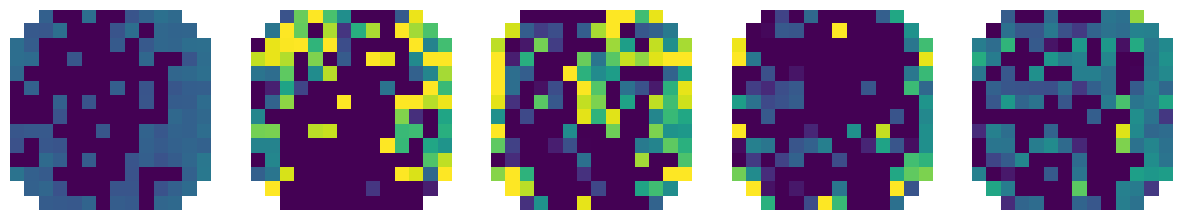

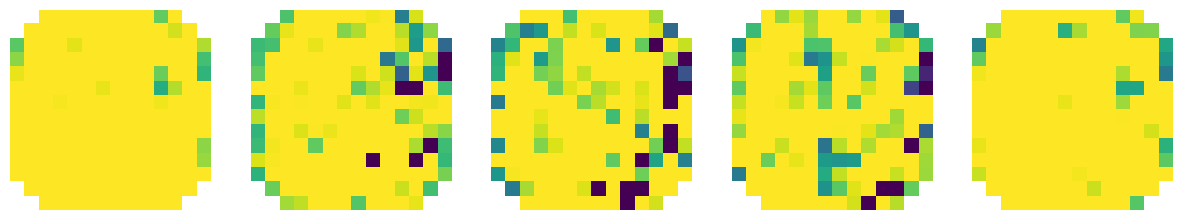

/tmp/ipykernel_65725/3323332524.py:20: RuntimeWarning: divide by zero encountered in log
  mat[i, j] = np.clip(np.log(v / (1 - v + 1e-5)), -2, 1.5)


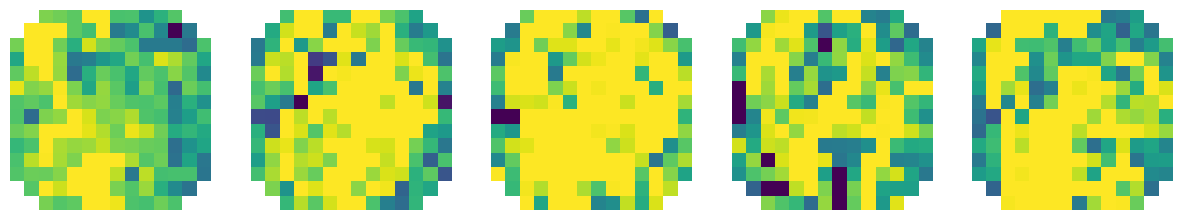

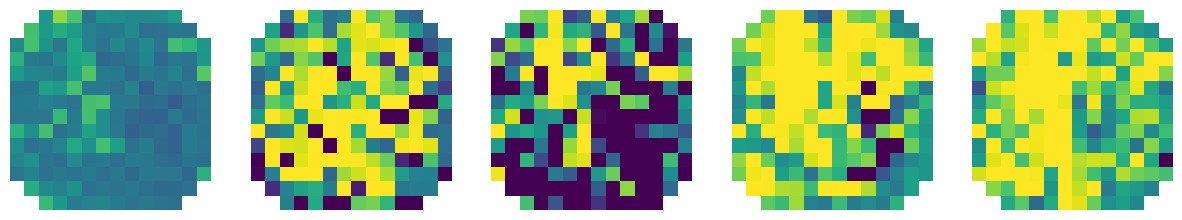

/tmp/ipykernel_65725/3323332524.py:20: RuntimeWarning: divide by zero encountered in log
  mat[i, j] = np.clip(np.log(v / (1 - v + 1e-5)), -2, 1.5)


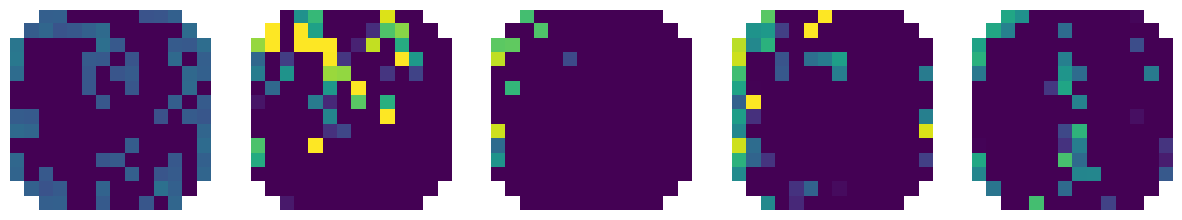

/tmp/ipykernel_65725/3323332524.py:20: RuntimeWarning: divide by zero encountered in log
  mat[i, j] = np.clip(np.log(v / (1 - v + 1e-5)), -2, 1.5)


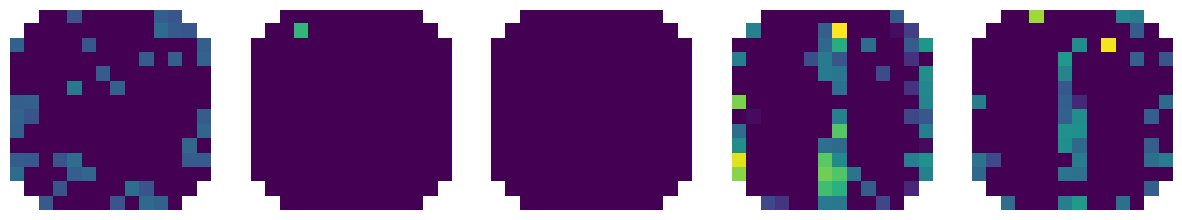

In [129]:
for well in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']:
    mats = plot_as_well(pred_val_dfs['Validation: 3R'], 
                 well,
                 use_cols=['label', 'D5_pred', 'D6_pred', 'D7_pred', 'D8_pred'])
    plt.show()
    # plt.savefig(os.path.join(SAVE_ROOT, 'fig1-well_%s_preds.pdf' % well), bbox_inches='tight')

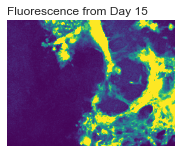

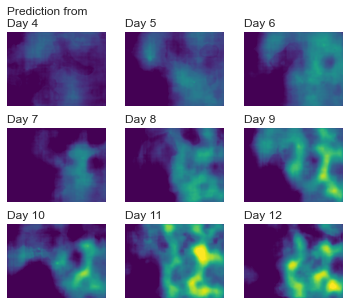

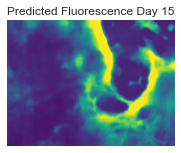

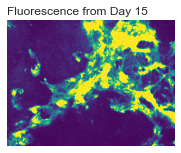

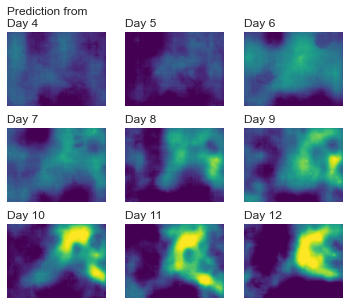

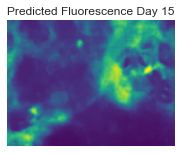

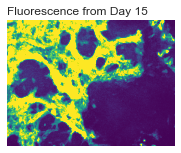

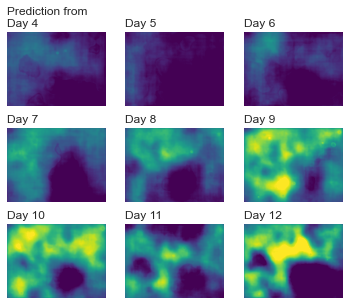

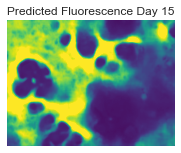

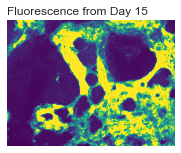

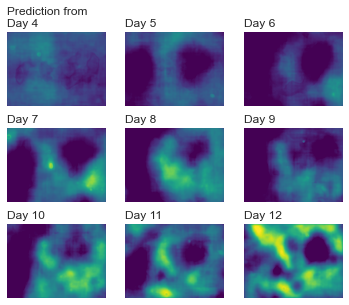

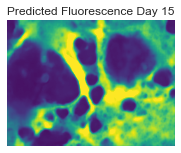

In [149]:
### Original validation set ###
# Gradual improvement of segmentation output

###
# import os
# import numpy as np
# import pandas as pd
# from collect_predictions import get_data_gen, CustomGenerator
# from data_loader import get_identifier

# root = "/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex15_full"
# valid_gen = get_data_gen(os.path.join(root, '0-to-0'), CustomGenerator, batch_size=8, with_label=True)
# identifier_mapping = {i: get_identifier(valid_gen.names[i]) for i in valid_gen.names}
# all_wells = set([idt[-2:] for idt in identifier_mapping.values()])

# seg_preds = [os.path.join(root, 'ex-valid-pred-to-15', f) \
#              for f in os.listdir(os.path.join(root, 'ex-valid-pred-to-15')) if f.startswith('seg')]

# sample_labels = {}
# for w in all_wells:
#     final_fl_id = [i for i in identifier_mapping if identifier_mapping[i][-2:] == w and identifier_mapping[i][2] == '15'][0]
#     if np.argmax(valid_gen.classify_y[final_fl_id]) == 3:
#         sample_labels[w] = valid_gen.load_ind(final_fl_id, force_augment_off=True)[1:3]

# score_df = pd.DataFrame(-np.ones((len(sample_labels), 9)), 
#                         columns=np.arange(4, 13), 
#                         index=['-'.join(w) for w in sample_labels.keys()])

# for f in seg_preds:
#     print(f)
#     seg_p = pickle.load(open(f, 'rb'))
#     for sp, n in zip(seg_p['seg_preds'], seg_p['pred_names']):
#         well = get_identifier(n)[-2:]
#         d = int(get_identifier(n)[2])
#         if '-'.join(well) in score_df.index:
#             sl = sample_labels[well]
#             w = sl[1][..., 0]
#             y = sl[0][..., 3] * 3 + sl[0][..., 2] * 2 + sl[0][..., 1]
#             score_df.loc['-'.join(well)][d] = pearsonr(y[np.nonzero(w)], sp[np.nonzero(w)])[0]


# s_mat = np.array(score_df)
# samples = np.where((s_mat[:, 1] > 0.2) * (s_mat[:, 4] > 0.3) * (s_mat[:, 5] > 0.4) * (s_mat[:, 6] > 0.4))[0]
# output = {}
# for s in samples:
#     w = tuple(score_df.index[s].split('-'))
#     output[w] = {}
#     final_fl_id = [i for i in identifier_mapping if identifier_mapping[i][-2:] == w and identifier_mapping[i][2] == '15'][0]
#     output[w]['label'] = valid_gen.load_ind(final_fl_id, force_augment_off=True)[1]

# for f in seg_preds:
#     print(f)
#     seg_p = pickle.load(open(f, 'rb'))
#     for sp, n in zip(seg_p['seg_preds'], seg_p['pred_names']):
#         well = get_identifier(n)[-2:]
#         d = int(get_identifier(n)[2])
#         if well in output:
#             output[well][d] = sp
###

output = pickle.load(open('VALIDATION/line1_3R/ex15_full/cla_seg-pred_samples.pkl', 'rb'))
sample_ws = [('A3', '136'), ('A3', '80'), ('A2', '24'), ('A2', '61')]

for sample_w in sample_ws:
    y = output[sample_w]['label']
    y = y[..., 3] * 3 + y[..., 2] * 2 + y[..., 1]

    plt.figure(figsize=(3, 2.5))
    plt.title('Fluorescence from Day 15', loc='left')
    plt.imshow(y, vmin=0., vmax=2.5, cmap='viridis')
    plt.axis('off')
    plt.savefig(os.path.join(SAVE_ROOT, 'fig1-example_label_%s.pdf' % str(sample_w)), bbox_inches='tight')

    plt.figure(figsize=(6, 5))
    for d in np.arange(4, 13):
        plt.subplot(3, 3, d-3)
        plt.imshow(output[sample_w][d], vmin=0.5, vmax=2.25, cmap='viridis')
        title = 'Day %d' % d if d > 4 else 'Prediction from\nDay %d' % d
        plt.title(title, ha='left', loc='left')
        plt.axis('off')
    plt.savefig(os.path.join(SAVE_ROOT, 'fig1-example_pred_%s.pdf' % str(sample_w)), bbox_inches='tight')
    
    plt.figure(figsize=(3, 2.5))
    plt.title('Predicted Fluorescence Day 15', loc='left')
    plt.imshow(output[sample_w][15], vmin=0., vmax=2.25, cmap='viridis')
    plt.axis('off')
    plt.savefig(os.path.join(SAVE_ROOT, 'fig1-example_same-day-pred_%s.pdf' % str(sample_w)), bbox_inches='tight')
    

<br/><br/><br/><br/>
### Classification perf: Diff Institutions ###

In [285]:
curves = {}
pred_val_dfs = {}
pred_file_names = ['psp-valid-pred-to-15', 'psp-valid-pred-to-17', 'psp-valid-pred-to-18']
# pred_file_names = ['ex-test-pred-to-17', 'ex-test-pred-to-18']

line_paths = {
    # 'Test: UofT': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_institutions/ex_UofT/0-to-0',
    'Test: UTexas': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_institutions/ex_UTexas/0-to-0',
    'Test: UColorado': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_institutions/ex_UColorado/0-to-0',
}

for line_name, line_path in line_paths.items():
    label_dict = read_labels(line_path)
    pred_dicts = [load_cla_pred_as_dict(line_path.replace('0-to-0', pred_file_name)) for pred_file_name in pred_file_names if os.path.exists(line_path.replace('0-to-0', pred_file_name))]
    ens_pd = ensemble_multiple_cla_preds(pred_dicts)
    
    binary_label_dict = binarize_scores(label_dict, cutoff=2)
    binary_pred_dicts = [binarize_scores(pred_dict, cutoff=2) for pred_dict in pred_dicts]
    binary_ens_pd = binarize_scores(ens_pd, cutoff=2)
    
    # for pred_file_name, bin_pd in zip(pred_file_names, binary_pred_dicts):
    #     curves[pred_file_name], _ = report_series_accuracy(bin_pd, binary_label_dict, start=2, end=10, print_res=False, exclude_ambiguous=(not '3R' in line_name))

    auc_curve, pred_val_df = report_series_accuracy(binary_ens_pd, binary_label_dict, start=2, end=10, print_res=False, exclude_ambiguous=False)
    curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

curves['COMB'], _ = combine_multi_line_preds(pred_val_dfs, label_cutoff=0.5, start=4, end=10, exclude_ambiguous=False)


N-samples: 576	Pos rate: 0.302	Prec: 0.632	Recall: 0.385	F1: 0.479	AUC: 0.789
N-samples: 576	Pos rate: 0.302	Prec: 0.706	Recall: 0.511	F1: 0.593	AUC: 0.864
N-samples: 576	Pos rate: 0.302	Prec: 0.793	Recall: 0.747	F1: 0.769	AUC: 0.935
N-samples: 576	Pos rate: 0.302	Prec: 0.880	Recall: 0.672	F1: 0.762	AUC: 0.931
N-samples: 576	Pos rate: 0.302	Prec: 0.891	Recall: 0.655	F1: 0.755	AUC: 0.902
N-samples: 576	Pos rate: 0.302	Prec: 0.897	Recall: 0.598	F1: 0.717	AUC: 0.895
N-samples: 576	Pos rate: 0.302	Prec: 0.889	Recall: 0.644	F1: 0.747	AUC: 0.890


(0.4, 1.0)

<Figure size 640x480 with 0 Axes>

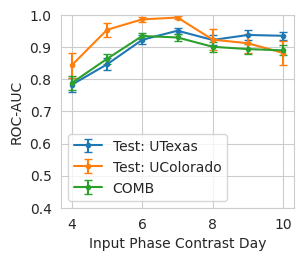

In [290]:
plt.clf()
plt.figure(figsize=(3, 2.5))
plot_kwargs = {'markersize': 3., 'linewidth': 1.5, 'capsize': 3.0, 'fmt': '-'}
plot_roc_auc_curves(curves, day_range=(4, 10), plot_median=False, plot_kwargs=plot_kwargs)
plt.legend()
plt.ylim(0.4, 1.0)
# plt.xticks(np.arange(4, 10))

<br/><br/><br/><br/>
### Classification perf: Drugs ###

In [446]:
line_name = 'Benzopyrene'
line_path = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_drugs/ex_multi_line_Benzopyrene/0-to-0'

# pred_file_names = ['psp-valid-pred-to-15', 'psp-valid-pred-to-17', 'psp-valid-pred-to-18']
pred_file_names = ['ex-test-pred-to-17', 'ex-test-pred-to-18']

# label_dict = read_labels(line_path)
# binary_label_dict = binarize_scores(label_dict, cutoff=2)

pred_dicts = [load_cla_pred_as_dict(line_path.replace('0-to-0', pred_file_name)) for pred_file_name in pred_file_names if os.path.exists(line_path.replace('0-to-0', pred_file_name))]
ens_pd = ensemble_multiple_cla_preds(pred_dicts)
binary_ens_pd = binarize_scores(ens_pd, cutoff=2)

In [441]:
# sns.set_style('white')
# well_matrix = np.zeros((8, 12))
# well_matrix_count = np.zeros((8, 12))

# for k, v in binary_label_dict.items():
#     well = k[-2]
#     i = ord(well[0]) - ord('A')
#     j = int(well[1:]) - 1
#     well_matrix[i, j] += v
#     well_matrix_count[i, j] += 1

# well_matrix = well_matrix / well_matrix_count
# plt.clf()
# plt.imshow(well_matrix, vmin=0, vmax=1.0)
# plt.xticks(np.arange(12), np.arange(1, 13))
# plt.yticks(np.arange(8), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
# plt.colorbar(shrink=0.7)
# plt.show()

<Figure size 640x480 with 0 Axes>

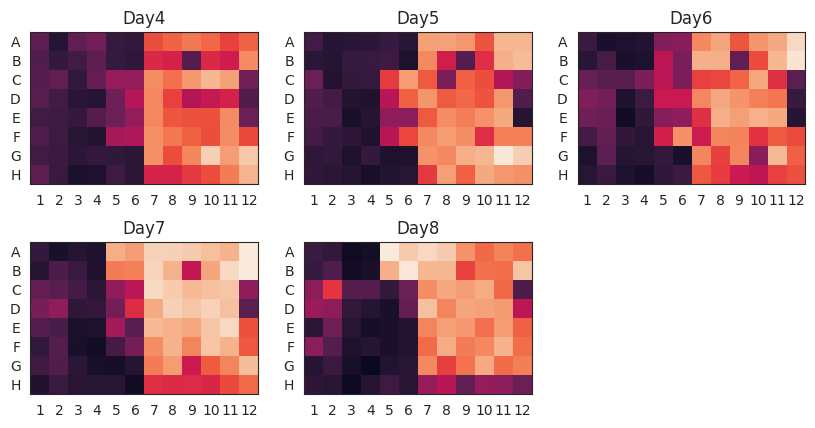

In [447]:
well_matrix_pred = np.zeros((5, 8, 12))
for k, v in binary_ens_pd.items():
    day = int(k[2])
    if day >= 4 and day <= 8:
        well = k[-2]
        i = ord(well[0]) - ord('A')
        j = int(well[1:]) - 1
        well_matrix_pred[day-4, i, j] += v
well_matrix_pred = well_matrix_pred / np.expand_dims(well_matrix_count, 0)

plt.clf()
plt.figure(figsize=(10, 5))
for i in range(5):
    # auc = roc_auc_score(((well_matrix > 0.4) * 1).flatten(), well_matrix_pred[i].flatten())
    # sr = spearmanr(well_matrix.flatten(), well_matrix_pred[i].flatten())
    plt.subplot(2, 3, i+1)
    plt.imshow(well_matrix_pred[i], vmin=0, vmax=0.8)
    plt.xticks(np.arange(12), np.arange(1, 13))
    plt.yticks(np.arange(8), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
    plt.title(f"Day{i+4}")# AUC {auc}, Spearman-r {sr[0]}", size=8)
plt.show()

<br/><br/>
### Predictions: MERSCOPE ###

Views are arranged in a 40-by-29 grid. Metrics are only calculated for the center views

In [151]:
selected_views = set()
well_center = (19.5, 15)
for i in range(40):
    for j in range(29):
        dist = np.sqrt((29 * (i - well_center[0]))**2 + (40 * (j - well_center[1]))**2)
        if dist < 380:
            selected_views.add(str(i * 29 + j + 1))

def arrange_views_in_matrix(pred_dict):
    """ Arrange 963 views from the MERSCOPE experiment into the corresponding matrix """
    well_matrix = -np.ones((40, 29))
    for k, v in pred_dict.items():
        view_pos = int(k[-1])
        irow = int((view_pos - 0.5) // 29)
        icol = int(view_pos % 29 - 1)
        well_matrix[irow, icol] = v
    return well_matrix

def binarize_score_for_hm(pred_dict):
    """ Customized scoring function for visualization """
    _pd = {}
    for k, v in pred_dict.items():
        assert np.allclose(1, v.sum())
        _v = (v[1] * 0.5 + v[2] * 2 + v[3] * 5) / 5
        _pd[k] = np.clip(_v, 0., 1.)
    return _pd


In [162]:
line_paths = {
    'MERSCOPE: slide7-neg': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex_Vizgen-slide7-neg/0-to-0',
    'MERSCOPE: slide15-pos': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex_Vizgen-slide15-pos/0-to-0',
    'MERSCOPE: slide17-pos': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex_Vizgen-slide17-pos/0-to-0',
}

# pred_file_names = ['psp-valid-pred-to-15', 'psp-valid-pred-to-17', 'psp-valid-pred-to-18']
pred_file_names = ['ex-test-pred-to-17', 'ex-test-pred-to-18']

combined_y_trues = []
combined_y_preds = []
pred_matrices = {}

for line, line_path in line_paths.items():
    # Collect predictions
    pred_dicts = [load_cla_pred_as_dict(line_path.replace('0-to-0', pred_file_name)) for pred_file_name in pred_file_names]
    ens_pd = ensemble_multiple_cla_preds(pred_dicts)
    ens_pd_metric = binarize_scores(ens_pd, cutoff=2)

    # Select center views for calculating binary metrics
    selected_ks = [k for k in ens_pd if k[-1] in selected_views]
    combined_y_preds.extend([ens_pd_metric[k] for k in selected_ks])
    combined_y_trues.extend([0. if 'neg' in line else 1.] * len(selected_ks))

    # Arrange prediction values into matrices for visualizations
    pred_matrix = arrange_views_in_matrix(binarize_score_for_hm(ens_pd))
    pred_matrices[line] = pred_matrix

# Binary metrics
y_trues = np.array(combined_y_trues)
y_preds = np.array(combined_y_preds)
binary_metrics = evaluate_binary_metric(y_trues, y_preds)


N-samples: 1170	Pos rate: 0.667	Prec: 0.929	Recall: 0.877	F1: 0.902	AUC: 0.945


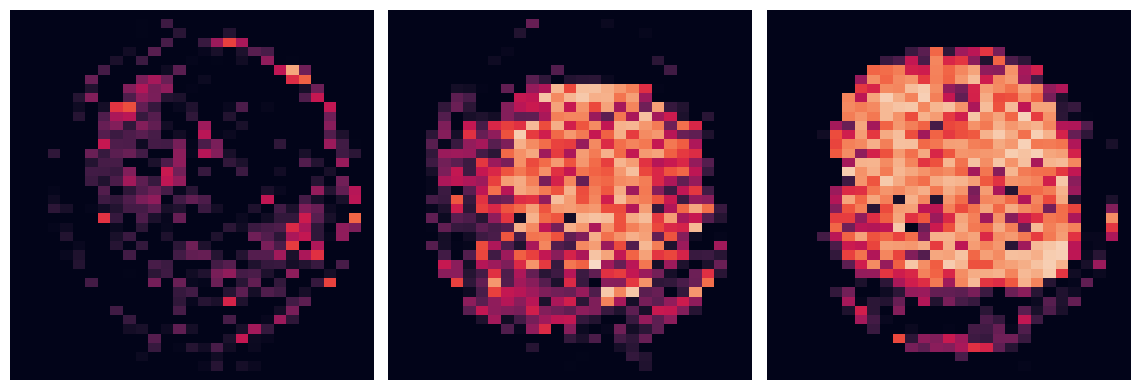

In [163]:
sns.set_style('white')
plt.figure(figsize=(11.5, 4))
for i, line in enumerate(pred_matrices.keys()):
    plt.subplot(1, 3, i+1)
    plt.imshow(pred_matrices[line], aspect='auto', vmin=0.2, vmax=0.8)
    plt.axis('off')
plt.tight_layout()
plt.show()

<br/><br/>
### Classification perf: prospective ###

In [82]:
curves = {}
pred_val_dfs = {}
pred_file_names = ['psp-valid-pred-to-15', 'psp-valid-pred-to-17', 'psp-valid-pred-to-18']
# pred_file_names = ['ex-test-pred-to-17', 'ex-test-pred-to-18']

line_name = "Prospective: 3R"
line_path = "/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/prospective_ex0/0-to-0"

label_dict = read_labels_from_fl(line_path, return_strategy='median')
pred_dicts = [load_cla_pred_as_dict(line_path.replace('0-to-0', pred_file_name)) for pred_file_name in pred_file_names if os.path.exists(line_path.replace('0-to-0', pred_file_name))]
ens_pd = ensemble_multiple_cla_preds(pred_dicts)

binary_label_dict = binarize_scores(label_dict, cutoff=2)
binary_pred_dicts = [binarize_scores(pred_dict, cutoff=1) for pred_dict in pred_dicts]
binary_ens_pd = binarize_scores(ens_pd, cutoff=1)

# for pred_file_name, bin_pd in zip(pred_file_names, binary_pred_dicts):
#     curves[pred_file_name], _ = report_series_accuracy(bin_pd, binary_label_dict, start=4, end=10, print_res=False)

auc_curve, pred_val_df = report_series_accuracy(binary_ens_pd, binary_label_dict, start=4, end=10, print_res=True, exclude_ambiguous=False)
curves[line_name] = auc_curve
pred_val_dfs[line_name] = pred_val_df

N-samples: 96	Pos rate: 0.385	Prec: 0.557	Recall: 0.919	F1: 0.694	AUC: 0.886
N-samples: 96	Pos rate: 0.385	Prec: 0.783	Recall: 0.973	F1: 0.867	AUC: 0.972
N-samples: 96	Pos rate: 0.385	Prec: 0.857	Recall: 0.973	F1: 0.911	AUC: 0.993
N-samples: 96	Pos rate: 0.385	Prec: 1.000	Recall: 0.486	F1: 0.655	AUC: 0.991
N-samples: 96	Pos rate: 0.385	Prec: 1.000	Recall: 0.568	F1: 0.724	AUC: 0.927
N-samples: 96	Pos rate: 0.385	Prec: 1.000	Recall: 0.405	F1: 0.577	AUC: 0.924
N-samples: 96	Pos rate: 0.385	Prec: 1.000	Recall: 0.270	F1: 0.426	AUC: 0.883


([<matplotlib.axis.XTick at 0x7f3d12db1dc0>,
 [Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8')])

<Figure size 640x480 with 0 Axes>

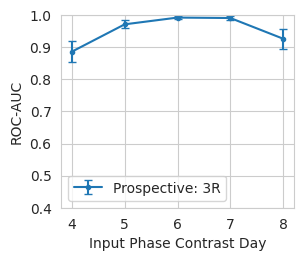

In [83]:
plt.clf()
plt.figure(figsize=(3, 2.5))
plot_kwargs = {'markersize': 3., 'linewidth': 1.5, 'capsize': 3.0, 'fmt': '-'}
plot_roc_auc_curves(curves, day_range=(4, 8), plot_median=False, plot_kwargs=plot_kwargs)
plt.legend()
plt.ylim(0.4, 1.0)
plt.xticks(np.arange(4, 9))

/tmp/ipykernel_10749/3281353627.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=x, y=y, palette='Blues')


([<matplotlib.axis.XTick at 0x7f3d1297a580>,
 [Text(0, 0, 'No Diff.'),
  Text(1, 0, 'Weak Diff.'),
  Text(2, 0, 'Strong Diff.')])

<Figure size 640x480 with 0 Axes>

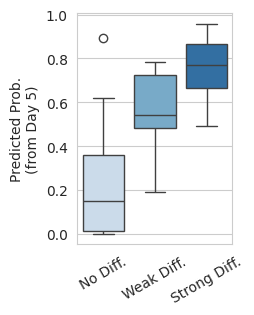

In [84]:
### Prediction box plot ###
names = pickle.load(open(os.path.join(line_path, 'names.pkl'), 'rb'))
classify_labels = pickle.load(open(os.path.join(line_path, 'classify_continuous_labels.pkl'), 'rb'))
well_labels = {}
for k in names:
    name = names[k]
    lab = classify_labels[k]
    well = get_identifier(name)[-2:]
    day = int(get_identifier(name)[2])
    if lab[1] > 0 and day >= 13:
        if not well in well_labels:
            well_labels[well] = {}
        well_labels[well][day] = lab[0]

label_dict = {k: np.argmax(np.stack(list(well_labels[k].values()), 0).mean(0)) for k in well_labels}
x = np.array([label_dict[k] for k in pred_val_df.index])
x[np.where(x == 2)] = 1
x[np.where(x == 3)] = 2
y = np.array(pred_val_df['D5_pred'])
plt.clf()
plt.figure(figsize=(2, 3))
sns.boxplot(x=x, y=y, palette='Blues')
# sns.swarmplot(x=x, y=y, color='k', size=2)
plt.ylabel("Predicted Prob.\n(from Day 5)")
plt.xticks([0, 1, 2], ["No Diff.", "Weak Diff.", "Strong Diff."], rotation=30)
# plt.savefig(os.path.join(SAVE_ROOT, 'supp-fig-prospective_box.pdf'), bbox_inches='tight')

<br/><br/>
### Classification perf: 12 well ###

In [148]:
curves = {}
pred_val_dfs = {}
pred_file_names = ['psp-valid-pred-to-15', 'psp-valid-pred-to-17', 'psp-valid-pred-to-18']
# pred_file_names = ['ex-test-pred-to-17', 'ex-test-pred-to-18']

line_paths = {
    '12-well: 3R': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_wells/12well/line1_3R/ex2-12well/0-to-0',
    '12-well: 839': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_wells/12well/line_839/ex0/0-to-0',
    '12-well: 975': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_wells/12well/line_975/ex0/0-to-0',
}

for line_name, line_path in line_paths.items():
    label_dict = read_labels(line_path)
    pred_dicts = [load_cla_pred_as_dict(line_path.replace('0-to-0', pred_file_name)) for pred_file_name in pred_file_names if os.path.exists(line_path.replace('0-to-0', pred_file_name))]
    ens_pd = ensemble_multiple_cla_preds(pred_dicts)
    
    binary_label_dict = binarize_scores(label_dict, cutoff=2)
    binary_pred_dicts = [binarize_scores(pred_dict, cutoff=2) for pred_dict in pred_dicts]
    binary_ens_pd = binarize_scores(ens_pd, cutoff=2)
    
    # for pred_file_name, bin_pd in zip(pred_file_names, binary_pred_dicts):
    #     curves[pred_file_name], _ = report_series_accuracy(bin_pd, binary_label_dict, start=2, end=10, print_res=False, exclude_ambiguous=(not '3R' in line_name))

    auc_curve, pred_val_df = report_series_accuracy(binary_ens_pd, binary_label_dict, start=2, end=10, print_res=True, exclude_ambiguous=(not '3R' in line_name))
    curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

curves['COMB'], _ = combine_multi_line_preds(pred_val_dfs, label_cutoff=0.5, start=4, end=8, exclude_ambiguous=False)

N-samples: 924	Pos rate: 0.464	Prec: 0.718	Recall: 0.711	F1: 0.714	AUC: 0.811
N-samples: 924	Pos rate: 0.464	Prec: 0.688	Recall: 0.730	F1: 0.708	AUC: 0.816
N-samples: 924	Pos rate: 0.464	Prec: 0.685	Recall: 0.751	F1: 0.716	AUC: 0.839
N-samples: 924	Pos rate: 0.464	Prec: 0.828	Recall: 0.739	F1: 0.781	AUC: 0.906
N-samples: 924	Pos rate: 0.464	Prec: 0.985	Recall: 0.744	F1: 0.847	AUC: 0.951
N-samples: 504	Pos rate: 0.478	Prec: 0.569	Recall: 0.324	F1: 0.413	AUC: 0.503
N-samples: 504	Pos rate: 0.478	Prec: 0.768	Recall: 0.647	F1: 0.703	AUC: 0.815
N-samples: 504	Pos rate: 0.478	Prec: 0.861	Recall: 0.643	F1: 0.736	AUC: 0.851
N-samples: 504	Pos rate: 0.478	Prec: 0.886	Recall: 0.548	F1: 0.677	AUC: 0.839
N-samples: 504	Pos rate: 0.478	Prec: 0.939	Recall: 0.444	F1: 0.603	AUC: 0.839
N-samples: 504	Pos rate: 0.478	Prec: 0.949	Recall: 0.701	F1: 0.807	AUC: 0.898
N-samples: 256	Pos rate: 0.754	Prec: 0.699	Recall: 0.301	F1: 0.420	AUC: 0.430
N-samples: 256	Pos rate: 0.754	Prec: 0.925	Recall: 0.762	F1: 0.8

(0.4, 1.0)

<Figure size 640x480 with 0 Axes>

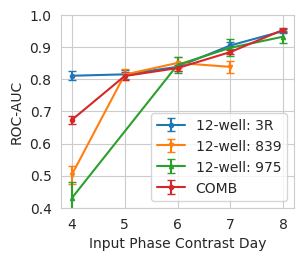

In [149]:
plt.clf()
plt.figure(figsize=(3, 2.5))
plot_kwargs = {'markersize': 3., 'linewidth': 1.5, 'capsize': 3.0, 'fmt': '-'}
plot_roc_auc_curves(curves, day_range=(4, 8), plot_median=False, plot_kwargs=plot_kwargs)
plt.legend()
plt.ylim(0.4, 1.0)
# plt.xticks(np.arange(4, 10))

<br/><br/>
### Classification perf: 24 well ###

In [73]:
curves = {}
pred_val_dfs = {}
pred_file_names = ['psp-valid-pred-to-15', 'psp-valid-pred-to-17', 'psp-valid-pred-to-18']
# pred_file_names = ['ex-test-pred-to-17', 'ex-test-pred-to-18']

line_paths = {
    '24-well: 3R': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_wells/24well/line1_3R/ex0-24well/0-to-0',
    '24-well: 839/975': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_wells/24well/line_975-839/ex0/0-to-0',
}

for line_name, line_path in line_paths.items():
    label_dict = read_labels(line_path)
    pred_dicts = [load_cla_pred_as_dict(line_path.replace('0-to-0', pred_file_name)) for pred_file_name in pred_file_names if os.path.exists(line_path.replace('0-to-0', pred_file_name))]
    ens_pd = ensemble_multiple_cla_preds(pred_dicts)
    
    binary_label_dict = binarize_scores(label_dict, cutoff=2)
    binary_pred_dicts = [binarize_scores(pred_dict, cutoff=2) for pred_dict in pred_dicts]
    binary_ens_pd = binarize_scores(ens_pd, cutoff=2)
    
    # for pred_file_name, bin_pd in zip(pred_file_names, binary_pred_dicts):
    #     curves[pred_file_name], _ = report_series_accuracy(bin_pd, binary_label_dict, start=2, end=10, print_res=False, exclude_ambiguous=(not '3R' in line_name))

    auc_curve, pred_val_df = report_series_accuracy(binary_ens_pd, binary_label_dict, start=2, end=10, print_res=True, exclude_ambiguous=(not '3R' in line_name))
    curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

curves['COMB'], _ = combine_multi_line_preds(pred_val_dfs, label_cutoff=0.5, start=4, end=8, exclude_ambiguous=False)

N-samples: 592	Pos rate: 0.041	Prec: 0.000	Recall: 0.000	F1: 0.000	AUC: 0.780
N-samples: 592	Pos rate: 0.041	Prec: 0.092	Recall: 0.292	F1: 0.140	AUC: 0.573
N-samples: 592	Pos rate: 0.041	Prec: 0.143	Recall: 0.542	F1: 0.226	AUC: 0.832
N-samples: 592	Pos rate: 0.041	Prec: 0.128	Recall: 0.667	F1: 0.215	AUC: 0.820
N-samples: 592	Pos rate: 0.041	Prec: 0.177	Recall: 0.708	F1: 0.283	AUC: 0.854
N-samples: 592	Pos rate: 0.041	Prec: 0.259	Recall: 0.583	F1: 0.359	AUC: 0.891
N-samples: 592	Pos rate: 0.041	Prec: 0.436	Recall: 0.708	F1: 0.540	AUC: 0.964
N-samples: 592	Pos rate: 0.041	Prec: 0.300	Recall: 0.875	F1: 0.447	AUC: 0.962
N-samples: 279	Pos rate: 0.756	Prec: 0.916	Recall: 0.773	F1: 0.838	AUC: 0.848
N-samples: 279	Pos rate: 0.756	Prec: 0.929	Recall: 0.621	F1: 0.744	AUC: 0.807
N-samples: 279	Pos rate: 0.756	Prec: 0.943	Recall: 0.474	F1: 0.631	AUC: 0.856
N-samples: 279	Pos rate: 0.756	Prec: 0.892	Recall: 0.668	F1: 0.764	AUC: 0.803
N-samples: 279	Pos rate: 0.756	Prec: 0.972	Recall: 0.815	F1: 0.8

/tmp/ipykernel_10749/1695140161.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(combined_df)


N-samples: 871	Pos rate: 0.270	Prec: 0.621	Recall: 0.613	F1: 0.617	AUC: 0.811
0.269804822043628
N-samples: 871	Pos rate: 0.270	Prec: 0.502	Recall: 0.494	F1: 0.498	AUC: 0.656
0.269804822043628
N-samples: 871	Pos rate: 0.270	Prec: 0.622	Recall: 0.672	F1: 0.646	AUC: 0.856
0.269804822043628
N-samples: 871	Pos rate: 0.270	Prec: 0.805	Recall: 0.791	F1: 0.798	AUC: 0.942


(0.4, 1.0)

<Figure size 640x480 with 0 Axes>

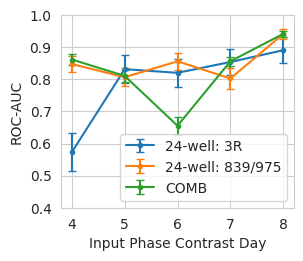

In [74]:
plt.clf()
plt.figure(figsize=(3, 2.5))
plot_kwargs = {'markersize': 3., 'linewidth': 1.5, 'capsize': 3.0, 'fmt': '-'}
plot_roc_auc_curves(curves, day_range=(4, 8), plot_median=False, plot_kwargs=plot_kwargs)
plt.legend()
plt.ylim(0.4, 1.0)
# plt.xticks(np.arange(4, 10))

<br/><br/>
### Classification perf: different differentiation media ###

In [145]:
curves = {}
pred_val_dfs = {}
pred_file_names = ['psp-valid-pred-to-15', 'psp-valid-pred-to-17', 'psp-valid-pred-to-18']
# pred_file_names = ['ex-test-pred-to-17', 'ex-test-pred-to-18']

line_paths = {
    'Diff. Media: 3R': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_differentiation/line1_3R/ex0/0-to-0',
    'Diff. Media: 839': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_differentiation/line_839/ex0/0-to-0',
    'Diff. Media: 975': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_differentiation/line_975/ex0/0-to-0',
}

for line_name, line_path in line_paths.items():
    label_dict = read_labels(line_path)
    pred_dicts = [load_cla_pred_as_dict(line_path.replace('0-to-0', pred_file_name)) for pred_file_name in pred_file_names if os.path.exists(line_path.replace('0-to-0', pred_file_name))]
    ens_pd = ensemble_multiple_cla_preds(pred_dicts)

    binary_label_dict = binarize_scores(label_dict, cutoff=2)
    binary_pred_dicts = [binarize_scores(pred_dict, cutoff=2) for pred_dict in pred_dicts]
    binary_ens_pd = binarize_scores(ens_pd, cutoff=2)
    
    # for pred_file_name, bin_pd in zip(pred_file_names, binary_pred_dicts):
    #     curves[pred_file_name], _ = report_series_accuracy(bin_pd, binary_label_dict, start=2, end=10, print_res=False, exclude_ambiguous=(not '3R' in line_name))

    auc_curve, pred_val_df = report_series_accuracy(binary_ens_pd, binary_label_dict, start=2, end=10, print_res=False, exclude_ambiguous=(not '3R' in line_name))
    if len(auc_curve) > 0:
        curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

curves['COMB'], _ = combine_multi_line_preds(pred_val_dfs, label_cutoff=0.5, start=4, end=8, exclude_ambiguous=False)

/tmp/ipykernel_10749/2217719021.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(combined_df)


N-samples: 1399	Pos rate: 0.399	Prec: 0.659	Recall: 0.797	F1: 0.722	AUC: 0.839
N-samples: 1399	Pos rate: 0.399	Prec: 0.475	Recall: 0.900	F1: 0.622	AUC: 0.770
N-samples: 1399	Pos rate: 0.399	Prec: 0.564	Recall: 0.715	F1: 0.630	AUC: 0.742
N-samples: 1399	Pos rate: 0.399	Prec: 0.628	Recall: 0.867	F1: 0.728	AUC: 0.858
N-samples: 1399	Pos rate: 0.399	Prec: 0.737	Recall: 0.672	F1: 0.703	AUC: 0.833


(0.4, 1.0)

<Figure size 640x480 with 0 Axes>

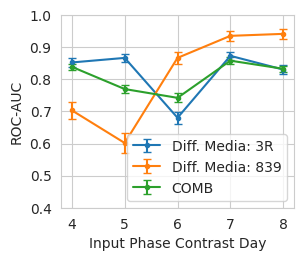

In [146]:
plt.clf()
plt.figure(figsize=(3, 2.5))
plot_kwargs = {'markersize': 3., 'linewidth': 1.5, 'capsize': 3.0, 'fmt': '-'}
plot_roc_auc_curves(curves, day_range=(4, 8), plot_median=False, plot_kwargs=plot_kwargs)
plt.legend()
plt.ylim(0.4, 1.0)
# plt.xticks(np.arange(4, 10))

<br/><br/>
### Classification perf: different instrument ###

In [100]:
curves = {}
pred_val_dfs = {}
pred_file_names = ['psp-valid-pred-to-15', 'psp-valid-pred-to-17', 'psp-valid-pred-to-18']
# pred_file_names = ['ex-test-pred-to-17', 'ex-test-pred-to-18']

line_paths = {
    'Diff. Instrument: 3R': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex2_other_instrument/0-to-0',
}

for line_name, line_path in line_paths.items():
    label_dict = read_labels(line_path)
    pred_dicts = [load_cla_pred_as_dict(line_path.replace('0-to-0', pred_file_name)) for pred_file_name in pred_file_names if os.path.exists(line_path.replace('0-to-0', pred_file_name))]
    ens_pd = ensemble_multiple_cla_preds(pred_dicts)

    binary_label_dict = binarize_scores(label_dict, cutoff=2)
    binary_pred_dicts = [binarize_scores(pred_dict, cutoff=2) for pred_dict in pred_dicts]
    binary_ens_pd = binarize_scores(ens_pd, cutoff=2)
    
    # for pred_file_name, bin_pd in zip(pred_file_names, binary_pred_dicts):
    #     curves[pred_file_name], _ = report_series_accuracy(bin_pd, binary_label_dict, start=2, end=10, print_res=False, exclude_ambiguous=(not '3R' in line_name))

    auc_curve, pred_val_df = report_series_accuracy(binary_ens_pd, binary_label_dict, start=2, end=10, print_res=False, exclude_ambiguous=False)
    curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

(0.4, 1.0)

<Figure size 640x480 with 0 Axes>

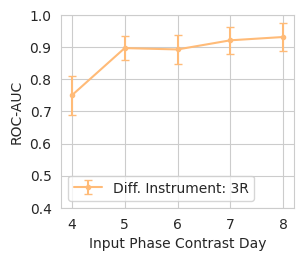

In [101]:
plt.clf()
plt.figure(figsize=(3, 2.5))
plot_kwargs = {'markersize': 3., 'linewidth': 1.5, 'capsize': 3.0, 'fmt': '-'}
plot_roc_auc_curves(curves, day_range=(4, 8), plot_median=False, plot_kwargs=plot_kwargs)
plt.legend()
plt.ylim(0.4, 1.0)
# plt.xticks(np.arange(4, 10))

<br/><br/>
### Classification perf: 10 additional lines ###

In [291]:
curves = {}
pred_val_dfs = {}
pred_file_names = ['psp-valid-pred-to-15', 'psp-valid-pred-to-17', 'psp-valid-pred-to-18']
# pred_file_names = ['ex-valid-pred-to-17', 'ex-valid-pred-to-18']

print(pred_file_names)
line_paths = {
    'Test: 477': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_477/ex0/0-to-0',
    'Test: 202': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_202/ex0/0-to-0',
    'Test: 20': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_20/ex0/0-to-0',
    'Test: 100': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_100/ex4/0-to-0',
    'Test: 142': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_142/ex1/0-to-0',
    'Test: 273': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_273/ex2/0-to-0',
    'Test: 839': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_839/ex1/0-to-0',
    'Test: 480': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_480/ex0/0-to-0',
    'Test: 854': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_854/ex1/0-to-0',
    'Test: 975': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line_975/ex0/0-to-0',
}

for line_name, line_path in line_paths.items():
    label_dict = read_labels(line_path)
    pred_dicts = [load_cla_pred_as_dict(line_path.replace('0-to-0', pred_file_name)) for pred_file_name in pred_file_names if os.path.exists(line_path.replace('0-to-0', pred_file_name))]
    ens_pd = ensemble_multiple_cla_preds(pred_dicts)

    binary_label_dict = binarize_scores(label_dict, cutoff=2)
    binary_pred_dicts = [binarize_scores(pred_dict, cutoff=2) for pred_dict in pred_dicts]
    binary_ens_pd = binarize_scores(ens_pd, cutoff=2)

    # for pred_file_name, bin_pd in zip(pred_file_names, binary_pred_dicts):
    #     curves[pred_file_name], _ = report_series_accuracy(bin_pd, binary_label_dict, start=4, end=10, print_res=False, exclude_ambiguous=True)

    auc_curve, pred_val_df = report_series_accuracy(binary_ens_pd, binary_label_dict, start=4, end=10, print_res=False, exclude_ambiguous=False)
    curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

combined_curve, _ = combine_multi_line_preds(pred_val_dfs, label_cutoff=0.5, start=4, end=9, exclude_ambiguous=True)

['psp-valid-pred-to-15', 'psp-valid-pred-to-17', 'psp-valid-pred-to-18']
N-samples: 8458	Pos rate: 0.575	Prec: 0.654	Recall: 0.714	F1: 0.683	AUC: 0.626
N-samples: 8458	Pos rate: 0.575	Prec: 0.723	Recall: 0.802	F1: 0.761	AUC: 0.745
N-samples: 7598	Pos rate: 0.603	Prec: 0.764	Recall: 0.884	F1: 0.820	AUC: 0.829
N-samples: 8458	Pos rate: 0.575	Prec: 0.817	Recall: 0.863	F1: 0.839	AUC: 0.884
N-samples: 8458	Pos rate: 0.575	Prec: 0.919	Recall: 0.831	F1: 0.873	AUC: 0.923
N-samples: 8458	Pos rate: 0.575	Prec: 0.928	Recall: 0.858	F1: 0.892	AUC: 0.937


(array([ 670.,  957.,  725.,  821., 1001.,  898.,  776.,  874., 1089.,
        1631.]),
 array([1.45413940e-29, 8.95371675e-02, 1.79074335e-01, 2.68611503e-01,
        3.58148670e-01, 4.47685838e-01, 5.37223005e-01, 6.26760173e-01,
        7.16297340e-01, 8.05834508e-01, 8.95371675e-01]),
 <BarContainer object of 10 artists>)

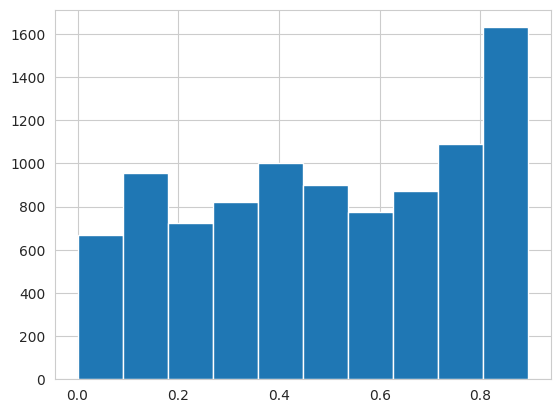

In [292]:
plt.hist(_['D8_pred'])

<Figure size 640x480 with 0 Axes>

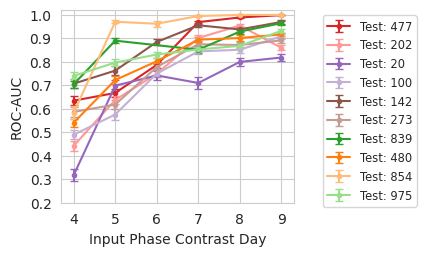

<Figure size 640x480 with 0 Axes>

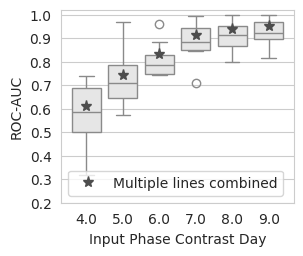

In [24]:
plt.clf()
plt.figure(figsize=(3, 2.5))
plot_kwargs = {'markersize': 3., 'linewidth': 1.5, 'capsize': 3.0, 'fmt': '-'}
plot_roc_auc_curves(curves, day_range=(4, 9), plot_median=False, plot_kwargs=plot_kwargs)
plt.ylim(0.2, 1.02)
plt.yticks(np.arange(0.2, 1.02, 0.1))
plt.xlim(3.7, 9.3)
plt.xticks(np.arange(4, 10))
plt.legend(loc='lower left', bbox_to_anchor=(1.1, -0.05), prop={'size': 8.3})
plt.show()
# plt.savefig(os.path.join(SAVE_ROOT, 'fig2-auc_curves.pdf'), bbox_inches='tight')

plt.clf()
plt.figure(figsize=(3, 2.5))
plot_roc_auc_box(curves, day_range=(4, 9))
plt.plot(np.arange(len(sorted(combined_curve.keys()))), 
         [combined_curve[k][3] for k in sorted(combined_curve.keys())], 
         '*', color=(0.3, 0.3, 0.3, 1.0), markersize=8, linewidth=1.6, label='Multiple lines combined', zorder=3)
plt.legend()
plt.ylim(0.2, 1.02)
plt.yticks(np.arange(0.2, 1.02, 0.1))
plt.show()
# plt.savefig(os.path.join(SAVE_ROOT, 'fig2-auc_boxes.pdf'), bbox_inches='tight')

<br/><br/><br/><br/>
## Generate Segmentation Output (Run on sherlock) ##

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import pickle
import numpy as np
import pandas as pd
import scipy
import cv2
import tifffile
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score

from data_loader import get_identifier, get_ex_day
from models import Segment, ClassifyOnSegment
from layers import load_partial_weights, fill_first_layer, evaluate_confusion_mat, summarize_conf_mat
from data_generator import CustomGenerator, PairGenerator, enhance_weight_for_false_positives


def get_day(n):
    return int(get_identifier(n)[2])


def get_ind(name, valid_ids):
    _id = get_identifier(name)
    if 'Z' in _id[-1]:
        _id = _id[:4] + tuple([_id[4].split('Z')[0]])
    for k in valid_ids:
        if _id[-3:] == valid_ids[k][-3:]:
            return k
    return None


def get_validation_data_gen(data_root):
    name_file = os.path.join(data_root, "names.pkl")
    X_ct = len([f for f in os.listdir(data_root) if f.startswith('X_')])
    X_files = [os.path.join(data_root, "X_%d.pkl" % i) for i in range(X_ct)]

    segment_y_files = [os.path.join(data_root, "segment_continuous_y_%d.pkl" % i) for i in range(X_ct)]
    segment_w_files = [os.path.join(data_root, "segment_continuous_w_%d.pkl" % i) for i in range(X_ct)]
    classify_label_file = os.path.join(data_root, "classify_continuous_labels.pkl")
    valid_gen = CustomGenerator(
        name_file,
        X_files, 
        segment_y_files=segment_y_files, 
        segment_w_files=segment_w_files,
        n_segment_classes=4,
        segment_class_weights=[1, 1, 1, 1],
        segment_label_type='continuous',
        classify_label_file=classify_label_file,
        n_classify_classes=4,
        classify_class_weights=[1, 1, 1, 1],
        classify_label_type='continuous')
    return valid_gen


def load_cla_preds(pred_paths):
    cla_dict = {}
    for pred_path in pred_paths:
        cla_result = pickle.load(open(os.path.join(pred_path, 'cla.pkl'), 'rb'))
        for name, pred in zip(cla_result['pred_names'], cla_result['cla_preds']):
            if not name in cla_dict:
                cla_dict[name] = []
            cla_dict[name].append(pred)
    
    cla_dict = {k: np.stack(v, 0).mean(0) for k, v in cla_dict.items()}
    return cla_dict


def collect_segmentation_performance(pred_paths, valid_gen, median_blur=False, skip_unlabeled=True):
    if isinstance(pred_paths, str):
        pred_paths = [pred_paths]
    fs = [[f for f in os.listdir(pred_path) if f.startswith('seg_') and f.endswith('.pkl')] for pred_path in pred_paths]
    assert all([set(fs[0]) == set(_fs) for _fs in fs])
        
    random_pixel_seg_preds = []
    random_pixel_seg_trues = []
    random_pixel_days = []
    random_pixel_ids = []

    sample_pearsonrs = []
    sample_days = []
    sample_ids = []
    
    day14_samples = []
    
    valid_ids = {k: get_identifier(v) for k, v in valid_gen.names.items()}
    cla_dict = load_cla_preds(pred_paths)
    for f in sorted(fs[0], key=lambda x: int(x.split('_')[1].split('.')[0])):
    
        seg_preds = []
        pred_names = []
        for pred_path in pred_paths:
            dat = pickle.load(open(os.path.join(pred_path, f), 'rb'))
            seg_preds.append(dat['seg_preds'])
            pred_names.append(dat['pred_names'])
        
        assert all([set(pred_names[0]) == set(p_n) for p_n in pred_names])
            
        for i, name in enumerate(pred_names[0]):

            s_pred = [s_preds[i] for s_preds in seg_preds]
            s_pred = np.stack(s_pred, 0).mean(0)
            
            name = name[0] if isinstance(name, tuple) else name
            sample_id = get_identifier(name)
            day = get_day(name)
            ind = get_ind(name, valid_ids)
            if ind is None:
                print("Cannot find %s" % str(sample_id))
                continue

            X, y, w, _ = valid_gen.load_ind(ind)
            if y is None or w is None:
                if skip_unlabeled:
                    continue
                y = np.zeros((X.shape[0], X.shape[1], 4))
                w = np.ones_like(X)
            s_true = y[..., 1] + y[..., 2] * 2 + y[..., 3] * 3
            if median_blur:
                s_true = cv2.medianBlur((s_true/3*255).astype(int).astype('uint8'), 13).astype(float) / 255 * 3
            
            s_w = w[..., 0]
            if s_w.sum() == 0:
                continue
            
            if day == 14:
                day14_samples.append((X, y, w, s_pred, name))

            _s_pred = s_pred[s_w == 1]
            _s_true = s_true[s_w == 1]
            pr = pearsonr(_s_pred, _s_true)[0]
            sample_pearsonrs.append(pr)
            sample_days.append(day)
            sample_ids.append(sample_id)

            rs_inds = np.random.choice(np.arange(_s_pred.shape[0]), (5000,), replace=False)
            if np.argmax(cla_dict[name]) == 0 and cla_dict[name][0] > 0.6: 
                # Strong classification signal as no differentiation
                _s_pred = np.zeros_like(_s_pred)
            random_pixel_seg_preds.append(_s_pred[rs_inds])
            random_pixel_seg_trues.append(_s_true[rs_inds])
            random_pixel_days.extend([day] * len(rs_inds))
            random_pixel_ids.extend([sample_id] * len(rs_inds))

    sample_score_df = pd.DataFrame({'pearson-r': sample_pearsonrs, 'day': sample_days}, index=sample_ids)
    random_pixel_df = pd.DataFrame({'pred': np.concatenate(random_pixel_seg_preds), 
                                    'true': np.concatenate(random_pixel_seg_trues), 
                                    'day': random_pixel_days,
                                    'id': random_pixel_ids})
    
    print("LABEL AVG: %.3f" % random_pixel_df['true'].mean())
    print("PRED AVG: %.3f" % random_pixel_df['pred'].mean())
    print("SAMPLE PR MEDIAN: %.3f" % np.nanmedian(sample_score_df['pearson-r']))
    print("SAMPLE (D>=12) PR MEDIAN: %.3f" % np.nanmedian(sample_score_df[sample_score_df['day'] >= 12]['pearson-r']))
    print("ALL PIXEL PR: %.3f" % pearsonr(random_pixel_df['true'], random_pixel_df['pred'])[0])
    print("ALL PIXEL (D>=12) PR: %.3f" % pearsonr(random_pixel_df[random_pixel_df['day'] >= 12]['true'], random_pixel_df[random_pixel_df['day'] >= 12]['pred'])[0])
    
    return sample_score_df, random_pixel_df, day14_samples


def pick_seg_pred_samples(valid_gen, day14_samples, seed=123):
    np.random.seed(seed)
    class_ct = {i: 0 for i in range(4)}

    write_samples = []
    day14_samples = sorted(day14_samples, key=lambda x: x[-1])
    np.random.shuffle(day14_samples)
    for s in day14_samples:
        X, y, w, s_pred, name = s
        j = [i for i, n in valid_gen.names.items() if n == name][0]
        cla_class = np.argmax(valid_gen.classify_y[j])
        if class_ct[cla_class] > 20:
            continue
        write_samples.append((X, y, w, s_pred, name))
        class_ct[cla_class] += 1
    return write_samples

In [277]:
### Original valid and test sets ###
ROOT = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/'
line_paths = {
    'Validation: 3R': ROOT + 'VALIDATION/line1_3R/ex15_full/',
    'Test: TNNI': ROOT + 'VALIDATION/line3_TNNI/ex4_full/',
    '12-well: 3R': ROOT + 'VALIDATION/different_wells/12well/line1_3R/ex2-12well/',
    '24-well: 3R': ROOT + 'VALIDATION/different_wells/24well/line1_3R/ex0-24well/',
    'Diff. Media: 3R': ROOT + 'VALIDATION/different_differentiation/line1_3R/ex0/',
}

pred_file_names = ['ex-valid-pred-to-0',]

for line, line_path in line_paths.items():
    pred_paths = [os.path.join(line_path, pred_file_name) for pred_file_name in pred_file_names]
    valid_gen = get_validation_data_gen(os.path.join(line_path, '0-to-0'))
    sample_score_df, random_pixel_df, day14_samples = collect_segmentation_performance(pred_paths, valid_gen, median_blur=False)
    with open(os.path.join(line_path, 'seg_summary.pkl'), 'wb') as f:
        pickle.dump([sample_score_df, random_pixel_df], f)
    with open(os.path.join(line_path, 'seg_samples.pkl'), 'wb') as f:
        pickle.dump(pick_seg_pred_samples(valid_gen, day14_samples, seed=123), f)
    if line == 'Test: TNNI':
        with open(os.path.join(line_path, 'seg_all.pkl'), 'wb') as f:
            pickle.dump(day14_samples, f)


<br/><br/><br/><br/>
## Segmentation perf: original validation/test ##

In [134]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

def get_pixel_level_correlation(pixel_df):
    curve = {}
    for d in sorted(set(pixel_df['day'])):
        sub_df = pixel_df[pixel_df['day'] == d]
        score = pearsonr(sub_df['true'], sub_df['pred'])[0]
        sd = []
        for _ in range(10):
            bs_inds = np.random.choice(np.arange(len(sub_df)), (int(0.1*len(sub_df)),), replace=False)
            sd.append(pearsonr(sub_df.iloc[bs_inds]['true'], sub_df.iloc[bs_inds]['pred'])[0])
        sd = np.std(sd)
        curve[d] = (score, sd)
    return curve



def boxplot_seg_pearsonr_distri(prs, 
                                properties,
                                boxplot_fig_output='seg_pearsonr_distri.png',
                                samplect_fig_output='seg_sample_count.png'):

    x_axis = sorted(set(properties))

    prs_by_x = {_x: [] for _x in x_axis}
    for pr, prop in zip(prs, properties):
        if pr == pr:
            prs_by_x[prop].append(pr)

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 3))
    red_diamond = dict(markerfacecolor='r', marker='D', markersize=2)
    data = [prs_by_x[_x] for _x in x_axis]
    bplot = ax.boxplot(
        data,
        notch=True,
        vert=True,
        patch_artist=True,
        positions=np.arange(len(x_axis)),
        flierprops=red_diamond,
        widths=0.2,
        manage_ticks=False)
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    ax.set_ylim(-0.41, 1.01)
    if not boxplot_fig_output is None:
        plt.savefig(boxplot_fig_output, dpi=300, bbox_inches='tight')
    else:
        plt.show()

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 1.5))
    ax.plot(np.arange(len(x_axis)), [len(prs_by_x[_x]) for _x in x_axis], c='pink')
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    ax.set_ylim([0, ax.get_ylim()[1]])
    if not samplect_fig_output is None:
        plt.savefig(samplect_fig_output, dpi=300, bbox_inches='tight')
    else:
        plt.show()

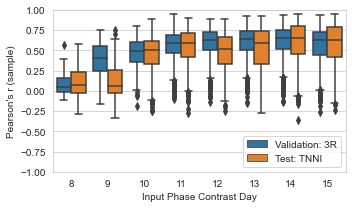

In [135]:
line_paths = {
    'Validation: 3R': 'VALIDATION/line1_3R/ex15_full/',
    'Test: TNNI': 'VALIDATION/line3_TNNI/ex4_full/',
}

seg_score_by_slice = []
seg_score_by_pixel = {}
for line, line_path in line_paths.items():
    seg_score1, seg_score2 = pickle.load(open(os.path.join(line_path, 'seg_summary.pkl'), 'rb'))
    seg_score1 = seg_score1.dropna()
    seg_score1['Dataset'] = [line] * len(seg_score1)
    seg_score_by_slice.append(seg_score1)
    # seg_score_by_pixel[line] = get_pixel_level_correlation(seg_score2)

plt.figure(figsize=(5, 3))
sns.boxplot(data=pd.concat(seg_score_by_slice), x='day', y='pearson-r', hue='Dataset', palette=color_mapping)
legend = plt.gca().legend(loc='upper left')
plt.ylim(-1.0, 1.0)
plt.xlabel('Input Phase Contrast Day')
plt.ylabel('Pearson\'s r (sample)')
plt.tight_layout()
legend = plt.gca().legend(loc='lower right')
plt.savefig(os.path.join(SAVE_ROOT, 'supp-fig-original_segmentation_perf_box.pdf'), bbox_inches='tight')

## Segmentation perf: original test samples ##

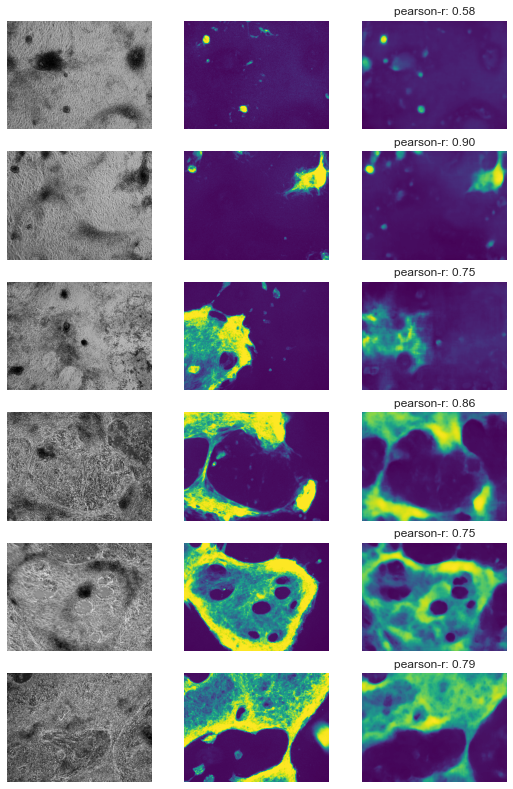

In [136]:
seg_samples = pickle.load(open('VALIDATION/line3_TNNI/ex4_full/seg_samples.pkl', 'rb'))
plot_samples = [
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/B2_05_1_98_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/B2_05_1_41_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/B1_04_1_126_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/A3_03_1_73_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/B1_04_1_187_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/line3_TNNI/ex4/210215_225152_az6well_gfp_TNNI_D14_ex4/210215_225152_Plate 1/B1_04_1_118_Phase Contrast_001.tif',
]

plt.figure(figsize=(9, 14))

seg_names = [s[-1] for s in seg_samples]
seg_score = pd.concat(seg_score_by_slice)
for i, n in enumerate(plot_samples):
    s = seg_samples[seg_names.index(n)]
    pr = seg_score.loc[[get_identifier(n)]]['pearson-r'][0]
    X = s[0][..., 0]
    y = s[1][..., 3]*3 + s[1][..., 2]*2 + s[1][..., 1]
    
    plt.subplot(6, 3, 3*i+1)
    plt.imshow(X, cmap='gray')
    plt.axis('off')
    plt.subplot(6, 3, 3*i+2)
    plt.imshow(y, cmap='viridis')
    plt.axis('off')
    plt.subplot(6, 3, 3*i+3)
    plt.imshow(s[3], cmap='viridis')
    plt.axis('off')
    plt.title('pearson-r: %.2f' % pr)
plt.savefig(os.path.join(SAVE_ROOT, 'supp-fig-original_segmentation_examples.pdf'), bbox_inches='tight')

<br/><br/>
## Segmentation perf: different well / media setting ##

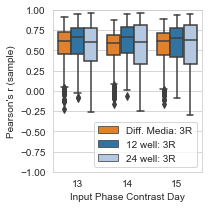

In [137]:
line_paths = {
#     'Test: Combined': 'VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex0-pre/',
    'Diff. Media: 3R': 'VALIDATION/different_differentiation/line1_3R/ex0/',
    '12 well: 3R': 'VALIDATION/different_wells/12well/line1_3R/ex2-12well/',
    '24 well: 3R': 'VALIDATION/different_wells/24well/line1_3R/ex0-24well/',
}

seg_score_by_slice = []
seg_score_by_pixel = {}
for line, line_path in line_paths.items():
    seg_score1, seg_score2 = pickle.load(open(os.path.join(line_path, 'seg_summary.pkl'), 'rb'))
    seg_score1 = seg_score1.dropna()
    seg_score1 = seg_score1[seg_score1['day'] >= 13]
    seg_score1['Dataset'] = [line] * len(seg_score1)
    seg_score_by_slice.append(seg_score1)
    # seg_score_by_pixel[line] = get_pixel_level_correlation(seg_score2)

plt.figure(figsize=(3, 3))
sns.boxplot(data=pd.concat(seg_score_by_slice), x='day', y='pearson-r', hue='Dataset', palette=color_mapping)
legend = plt.gca().legend(loc='lower right')
plt.ylim(-1.0, 1.0)
plt.xlabel('Input Phase Contrast Day')
plt.ylabel('Pearson\'s r (sample)')
plt.tight_layout()
plt.savefig(os.path.join(SAVE_ROOT, 'supp-fig-diff_condition_segmentation_perf_box.pdf'), bbox_inches='tight')

<br/><br/><br/><br/>
## Generate Segmentation Output for additional lines (Run on sherlock) ##

In [ ]:
import os
import numpy as np
import scipy
import pickle
from collect_predictions import get_model, get_data_gen
from data_generator import CustomGenerator

def collect_preds(valid_gen, 
                  model, 
                  pred_save_dir, 
                  input_transform=None, 
                  input_filter=None,
                  target_day=18):
    
    os.makedirs(pred_save_dir, exist_ok=True)

    pred_save = {"seg_preds": [], "seg_trues": [], "seg_ws": [], "pred_names": []}
    file_ct = 0
    cla_preds = []
    cla_trues = []
    cla_ws = []
    pred_names = []

    for batch in valid_gen:
        X = batch[0]
        names = batch[-1]
        if not input_filter is None:
            inds = input_filter(batch)
        else:
            inds = np.arange(X.shape[0])
        if len(inds) == 0:
            continue
        if not input_transform is None:
            X = input_transform(X)
        
        ###   
        X[..., 1] = target_day
        ###
        
        pred = model.model.predict(X)
        seg_pred = scipy.special.softmax(pred[0], -1)
        seg_pred = seg_pred[..., 1] + seg_pred[..., 2]*2 + seg_pred[..., 3] * 3
        pred_save["seg_preds"].extend([seg_pred[i] for i in inds])

        cla_pred = scipy.special.softmax(pred[1], -1)
        cla_preds.extend([cla_pred[i] for i in inds])

        pred_save["pred_names"].extend([names[i] for i in inds])
        pred_names.extend([names[i] for i in inds])

        if not batch[1] is None:
            seg_true, cla_true = batch[1]
            seg_y = seg_true[..., 1] + seg_true[..., 2]*2 + seg_true[..., 3] * 3
            seg_w = seg_true[..., -1]
            cla_y, cla_w = cla_true[..., :-1], cla_true[..., -1]
            pred_save["seg_trues"].extend([seg_y[i] for i in inds])
            pred_save["seg_ws"].extend([seg_w[i] for i in inds])
        
            cla_trues.extend([cla_y[i] for i in inds])
            cla_ws.extend([cla_w[i] for i in inds])

        if len(pred_save["seg_preds"]) >= 500:
            with open(os.path.join(pred_save_dir, "seg_%d.pkl" % file_ct), 'wb') as f:
                pickle.dump(pred_save, f)
            pred_save = {"seg_preds": [], "seg_trues": [], "seg_ws": [], "pred_names": []}
            file_ct += 1

    with open(os.path.join(pred_save_dir, "seg_%d.pkl" % file_ct), 'wb') as f:
        pickle.dump(pred_save, f)
        
    with open(os.path.join(pred_save_dir, "cla.pkl"), 'wb') as f:
        pickle.dump({"cla_preds": np.stack(cla_preds, 0),
                     "cla_trues": np.stack(cla_trues, 0) if len(cla_trues) > 0 else cla_trues,
                     "cla_ws": np.stack(cla_ws, 0) if len(cla_ws) > 0 else cla_ws,
                     "pred_names": pred_names}, f)

In [ ]:
### Generate prediction for additional lines in 24 well ###
ROOT = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/'
line_path = ROOT + 'VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex0-pre/'
valid_gen = get_data_gen(os.path.join(line_path, '0-to-0'), CustomGenerator, batch_size=8, with_label=False)

target_day = 20
for m, model_path in {'valid': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/model_save/ex_split/0-to-0_ex/bkp.model',
                      'test': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/model_save/ex_split/0-to-0_ex/test-bkp.model'}.items():
    model = get_model(model_path)
    collect_preds(valid_gen, 
                  model, 
                  os.path.join(line_path, 'ex-%s-pred-to-0_as-D%d' % (m, target_day)), 
                  input_transform=None, 
                  input_filter=None,
                  target_day=target_day)

### Collect prediction for additional lines in 24 well ###
pred_file_names = ['ex-valid-pred-to-0_as-D20', 'ex-test-pred-to-0_as-D20']
pred_paths = [os.path.join(line_path, pred_file_name) for pred_file_name in pred_file_names]
valid_gen = get_validation_data_gen(os.path.join(line_path, '0-to-0'))
sample_score_df, random_pixel_df, _ = \
    collect_segmentation_performance(pred_paths, valid_gen, median_blur=True, skip_unlabeled=False)
_, _, day14_samples = \
    collect_segmentation_performance(pred_paths, valid_gen, median_blur=False, skip_unlabeled=True)

# Exclude Day12-B1, Day12-D4, Day14-B1 due to blurry input / artifact
excluded = [('12', 'B1'), ('12', 'D4'), ('14', 'B1')]
sample_score_df = sample_score_df.loc[[w for w in sample_score_df.index if not tuple(w[2:4]) in excluded]]
random_pixel_df_valid_inds = [i for i, _id in zip(random_pixel_df.index, random_pixel_df['id']) if not _id[2:4] in excluded]
random_pixel_df = random_pixel_df.loc[random_pixel_df_valid_inds]
day14_samples = [s for s in day14_samples if not get_identifier(s[-1])[2:4] in excluded]

with open(os.path.join(line_path, 'seg_summary.pkl'), 'wb') as f:
    pickle.dump([sample_score_df, random_pixel_df], f)
with open(os.path.join(line_path, 'seg_samples.pkl'), 'wb') as f:
    pickle.dump(pick_seg_pred_samples(valid_gen, day14_samples, seed=123), f)
with open(os.path.join(line_path, 'seg_full.pkl'), 'wb') as f:
    pickle.dump(day14_samples, f)

<br/><br/><br/><br/>
## Segmentation perf: addtional lines ##

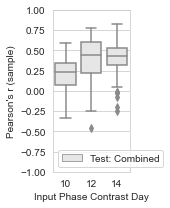

In [139]:
ROOT = './'
line_paths = {
    'Test: Combined': ROOT + 'VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex0-pre/'
}

seg_score_by_slice = []
seg_score_by_pixel = {}
for line, line_path in line_paths.items():
    seg_score1, seg_score2 = pickle.load(open(os.path.join(line_path, 'seg_summary.pkl'), 'rb'))
    seg_score1 = seg_score1.dropna()
    seg_score1 = seg_score1[seg_score1['day'] >= 10]
    seg_score1['Dataset'] = [line] * len(seg_score1)
    seg_score_by_slice.append(seg_score1)
    # seg_score_by_pixel[line] = get_pixel_level_correlation(seg_score2)

plt.figure(figsize=(2, 3))
sns.boxplot(data=pd.concat(seg_score_by_slice), x='day', y='pearson-r', hue='Dataset', palette=color_mapping)
_ = plt.gca().legend(loc='lower right').remove()
plt.ylim(-1.0, 1.0)
plt.xlabel('Input Phase Contrast Day')
plt.ylabel('Pearson\'s r (sample)')
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(SAVE_ROOT, 'supp-fig-additional_lines_segmentation_perf_box.pdf'), bbox_inches='tight')

## Segmentation perf: addtional lines example ##

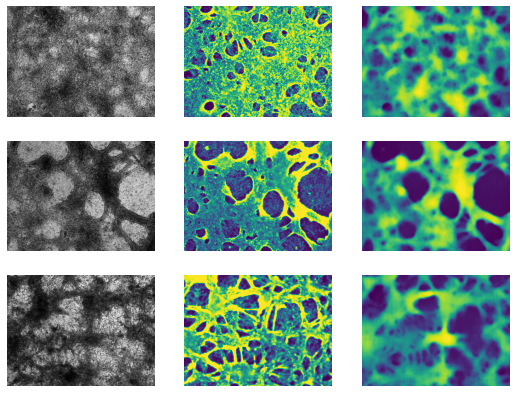

In [140]:
seg_samples = pickle.load(open('VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex0-pre/seg_samples.pkl', 'rb'))

plot_samples = [
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/additional_lines_for_seg/line_additional-combined-24/ex0-pre/220130_213610_az24well_multiline_segmentation_D14_phase/220130_213610_Plate 1/A1_02_1_7_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/additional_lines_for_seg/line_additional-combined-24/ex0-pre/220130_213610_az24well_multiline_segmentation_D14_phase/220130_213610_Plate 1/A1_02_1_34_Phase Contrast_001.tif',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/additional_lines_for_seg/line_additional-combined-24/ex0-pre/220130_213610_az24well_multiline_segmentation_D14_phase/220130_213610_Plate 1/D5_21_1_17_Phase Contrast_001.tif',
]
plt.figure(figsize=(9, 7))
seg_names = [s[-1] for s in seg_samples]
for i, n in enumerate(plot_samples):
    s = seg_samples[seg_names.index(n)]
    X = s[0][..., 0]
    y = s[1][..., 3]*3 + s[1][..., 2]*2 + s[1][..., 1]
    
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(X, cmap='gray')
    plt.axis('off')
    plt.subplot(3, 3, 3*i+2)
    plt.imshow(y, cmap='viridis')
    plt.axis('off')
    plt.subplot(3, 3, 3*i+3)
    plt.imshow(s[3], cmap='viridis')
    plt.axis('off')
plt.savefig(os.path.join(SAVE_ROOT, 'supp-fig-additional_lines_segmentation_examples.pdf'), bbox_inches='tight')

<br/><br/><br/><br/>
## Segmentation perf: addtional lines example-by-score ##

0.014834951056224689
0.11808002594050268
0.2555035898038731
0.3998232188509129
0.5100216612692619
0.6558270304541229


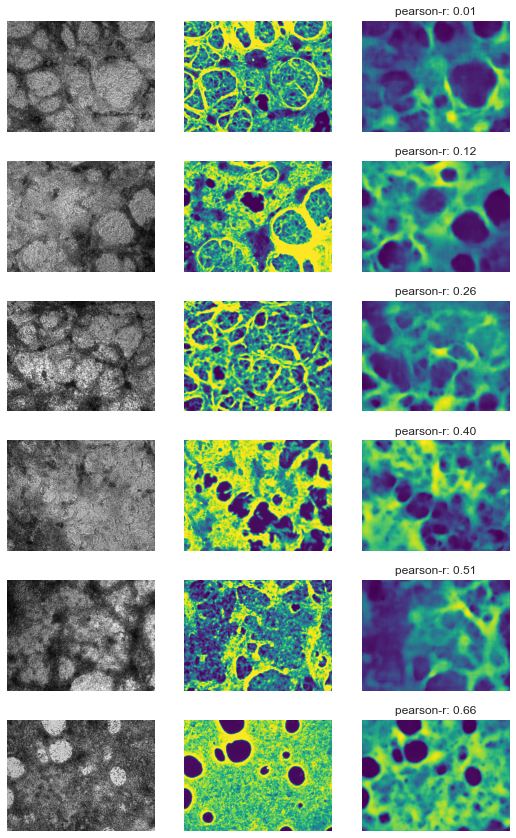

In [141]:
seg_full = pickle.load(open('VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex0-pre/seg_full.pkl', 'rb'))
seg_score = pickle.load(open('VALIDATION/additional_lines_for_seg/line_additional-combined-24/ex0-pre/seg_summary2.pkl', 'rb'))[0]

plot_samples = [
    ('line_additional-combined-24', 'ex0-pre', '14', 'B5', '28'),
    ('line_additional-combined-24', 'ex0-pre', '14', 'B5', '15'),
    ('line_additional-combined-24', 'ex0-pre', '14', 'D5', '5'),
    ('line_additional-combined-24', 'ex0-pre', '14', 'B5', '20'),
    ('line_additional-combined-24', 'ex0-pre', '14', 'D2', '7'),
    ('line_additional-combined-24', 'ex0-pre', '14', 'C1', '17'),
]

plt.figure(figsize=(9, 15))
n_rows = len(plot_samples)

for i, s in enumerate(plot_samples):
    pr = seg_score.loc[[s]]['pearson-r'][0]
    print(pr)
    p = [p for p in seg_full if get_identifier(p[-1]) == s][0]
    
    X = p[0][..., 0]
    y = p[1][..., 3]*3 + p[1][..., 2]*2 + p[1][..., 1]
    
    plt.subplot(n_rows, 3, i*3+1)
    plt.imshow(X, cmap='gray')
    plt.axis('off')
    plt.subplot(n_rows, 3, i*3+2)
    plt.imshow(y, cmap='viridis')
    plt.axis('off')
    plt.subplot(n_rows, 3, i*3+3)
    plt.imshow(p[3], cmap='viridis')
    plt.axis('off')
    plt.title("pearson-r: %.2f" % pr)
    
plt.savefig(os.path.join(SAVE_ROOT, 'supp-fig-additional_lines_segmentation_examples2.pdf'), bbox_inches='tight')

<br/><br/><br/><br/>
## Training logs ##

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt


def read_log(folder='fpn'):
    final_blocks = separate_blocks(os.path.join('TRAIN_LOGS', folder, 'LOG'))
    n_blocks = len(final_blocks)
    
    start = 0
    training_traj = {}
    for i in range(n_blocks):
        blocks = separate_blocks(os.path.join('TRAIN_LOGS', folder, 'run%d.log' % i))
        if i < n_blocks - 1:
            block_end = list(final_blocks.keys())[i]
        else:
            block_end = len(blocks)
        for i in range(1, block_end+1):
            training_traj[i + start] = read_block(blocks[i])
        start = start + block_end
    return training_traj


def separate_blocks(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    blocks = {}
    block = []
    for line in lines:
        if line.startswith('Epoch'):
            if block[0].startswith('Epoch'):
                epoch_num = int(block[0].split()[1].split('/')[0])
                block = [l for l in block if len(l) > 1]
                blocks[epoch_num] = block
            block = []
        block.append(line)
    
    if len(blocks) == 0 or len(block) > 0.5 * len(blocks[list(blocks.keys())[0]]):
        epoch_num = int(block[0].split()[1].split('/')[0])
        blocks[epoch_num] = block
    return blocks


def read_block(block):
    score = {}
    score_block = None
    for l in block:
        if 'loss' in l:
            loss_items = {}
            for item in l.split('-'):
                if 'loss' in item:
                    k, v = item.strip().split(' ')
                    loss_items[k] = float(v)
            score['loss_items'] = loss_items
        if l.startswith('Segmentation'):
            score_block = 'Segmentation'
        if l.startswith('Classification'):
            score_block = 'Classification'
        if score_block is None:
            continue
            
        if l.startswith('Accuracy'):
            score['%s-acc' % score_block] = float(l.split()[1])
        if l.startswith('Error (Higher pred)'):
            error_ar = []
            for item in l.split('-')[1:]:
                error_ar.append(float(item.split()[0]))
            score['%s-err_high' % score_block] = error_ar
        if l.startswith('Error (Lower pred)'):
            error_ar = []
            for item in l.split('-')[1:]:
                error_ar.append(float(item.split()[0]))
            score['%s-err_low' % score_block] = error_ar
    return score


def get_err(traj, _x):
    return traj[_x]['Classification-err_high'][-1] + traj[_x]['Classification-err_low'][-1]


def get_acc(traj, _x):
    return traj[_x]['Classification-acc']


<Figure size 432x288 with 0 Axes>

<Figure size 216x180 with 0 Axes>

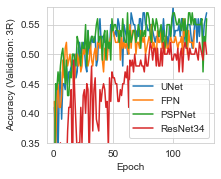

In [27]:
method_name_mapping = {
    'UNet': 'unet',
    'FPN': 'fpn',
    'PSPNet': 'pspnet',
    'ResNet34': 'resnet',
}

trajs = {k: read_log(v) for k, v in method_name_mapping.items()}

# ERR curve
plt.clf()
plt.figure(figsize=(3, 2.5))
for k in trajs:
    x = sorted(trajs[k].keys())[:128]
    y = [get_err(trajs[k], _x) for _x in x]
    plt.plot(x, y, label=k)
plt.ylim(1.5, 8)
plt.legend()
plt.ylabel('Error (Validation: 3R)')
plt.xlabel('Epoch')
plt.savefig(os.path.join(SAVE_ROOT, 'suppfig1', 'supp-fig1-training_curve_error.png'), bbox_inches='tight', dpi=300)

# ACC curve
plt.clf()
plt.figure(figsize=(3, 2.5))
for k in trajs:
    x = sorted(trajs[k].keys())[:128]
    y = [get_acc(trajs[k], _x) for _x in x]
    plt.plot(x, y, label=k)

plt.ylim(0.35, 0.58)
plt.legend()
plt.ylabel('Accuracy (Validation: 3R)')
plt.xlabel('Epoch')
plt.savefig(os.path.join(SAVE_ROOT, 'suppfig1', 'supp-fig1-training_curve_acc.png'), bbox_inches='tight', dpi=300)

<br/><br/><br/><br/>
## Model Structure Benchmarking ##

N-samples: 478	Pos rate: 0.502	Prec: 0.829	Recall: 0.242	F1: 0.374	AUC: 0.747
N-samples: 478	Pos rate: 0.502	Prec: 0.958	Recall: 0.383	F1: 0.548	AUC: 0.822
N-samples: 478	Pos rate: 0.502	Prec: 0.954	Recall: 0.429	F1: 0.592	AUC: 0.847
N-samples: 478	Pos rate: 0.502	Prec: 0.963	Recall: 0.429	F1: 0.594	AUC: 0.867
N-samples: 478	Pos rate: 0.502	Prec: 0.983	Recall: 0.475	F1: 0.640	AUC: 0.887
N-samples: 478	Pos rate: 0.502	Prec: 0.957	Recall: 0.642	F1: 0.768	AUC: 0.916
N-samples: 478	Pos rate: 0.502	Prec: 0.603	Recall: 0.746	F1: 0.667	AUC: 0.675
N-samples: 478	Pos rate: 0.502	Prec: 0.843	Recall: 0.650	F1: 0.734	AUC: 0.846
N-samples: 478	Pos rate: 0.502	Prec: 0.821	Recall: 0.671	F1: 0.739	AUC: 0.850
N-samples: 478	Pos rate: 0.502	Prec: 0.882	Recall: 0.625	F1: 0.732	AUC: 0.872
N-samples: 478	Pos rate: 0.502	Prec: 0.889	Recall: 0.738	F1: 0.806	AUC: 0.885
N-samples: 478	Pos rate: 0.502	Prec: 0.833	Recall: 0.787	F1: 0.809	AUC: 0.887
N-samples: 478	Pos rate: 0.502	Prec: 0.623	Recall: 0.771	F1: 0.6

<Figure size 432x288 with 0 Axes>

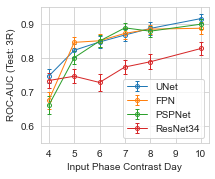

In [38]:
line = 'Test: 3R'
line_path = 'VALIDATION/line1_3R/ex7_full/'
label_dict = pickle.load(open(os.path.join(line_path, 'cla_labels.pkl'), 'rb'))

pred_file_mapping = {
    'UNet': 'ex-valid-pred-to-15_UNET',
    'FPN': 'ex-valid-pred-to-15_FPN',
    'PSPNet': 'ex-valid-pred-to-15_PSPNET',
    'ResNet34': 'ex-valid-pred-to-15_RESNET',
}
pred_cutoff = 1


plt.clf()
plt.figure(figsize=(3, 2.5))
for method_name, pred_file_name in pred_file_mapping.items():

    pred_dicts = [load_cla_pred_as_dict(os.path.join(line_path, pred_file_name))]
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                    label_dict, 
                                                    exclude_ambiguous=False, 
                                                    pred_cutoff=pred_cutoff,
                                                    label_cutoff=0.5,
                                                    start=4,
                                                    end=10)
    

    x = sorted(auc_curve.keys())
    y = [auc_curve[_x][3] for _x in x]
    yerr = [auc_curve[_x][4][1] for _x in x]
    plt.errorbar(x, 
                 y, 
                 yerr=yerr, 
                 fmt='-', 
                 marker='o',
                 mfc='none',
                 markersize=4, 
                 linewidth=1.0, 
                 capsize=2.0,
                 label=method_name)
plt.ylim(0.55, 0.95)
plt.yticks([0.6, 0.7, 0.8, 0.9])
plt.xticks([4, 5, 6, 7, 8, 9, 10])
plt.legend(loc='lower right')
plt.xlabel("Input Phase Contrast Day")
plt.ylabel("ROC-AUC (%s)" % line)
plt.savefig(os.path.join(SAVE_ROOT, 'suppfig1', 'supp-fig1-model_structure_benchmarking.png'), dpi=300, bbox_inches='tight')

<br/><br/><br/><br/>
## Schematics ##

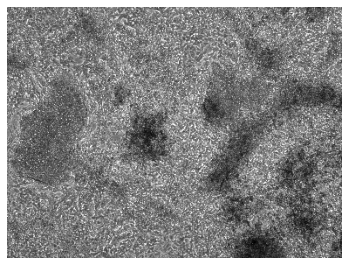

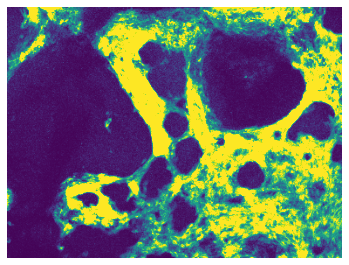

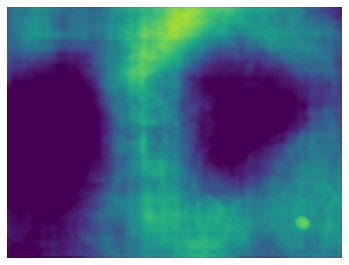

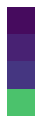

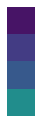

In [37]:
sample_w = ('A2', '61')
sample_input_day = 5

# Input phase contrast
names = pickle.load(open('VALIDATION/line1_3R/ex15_full/0-to-0/names.pkl', 'rb'))
sample = [i for i, n in names.items() if \
          get_identifier(n)[-2:] == sample_w and get_identifier(n)[2] == str(sample_input_day)][0]
Xs = pickle.load(open('VALIDATION/line1_3R/ex15_full/0-to-0/X_%d.pkl' % (sample//100), 'rb'))
X = Xs[sample][..., 0]
plt.figure(figsize=(6, 5))
plt.imshow(X, cmap='gray')
plt.axis('off')
plt.savefig(os.path.join(SAVE_ROOT, 'suppfig1', 'supp-fig1-schematics-input.pdf'), bbox_inches='tight')

# Seg-label
output = pickle.load(open('VALIDATION/line1_3R/ex15_full/cla_seg-pred_samples.pkl', 'rb'))
y = output[sample_w]['label']
y = y[..., 3] * 3 + y[..., 2] * 2 + y[..., 1]
plt.figure(figsize=(6, 5))
plt.imshow(y, vmin=0., vmax=2.5, cmap='viridis')
plt.axis('off')
plt.savefig(os.path.join(SAVE_ROOT, 'suppfig1', 'supp-fig1-schematics-seg-label.pdf'), bbox_inches='tight')

# Seg-pred
_y = output[sample_w][5]
plt.figure(figsize=(6, 5))
plt.imshow(_y, vmin=0.5, vmax=1.5, cmap='viridis')
plt.axis('off')
plt.savefig(os.path.join(SAVE_ROOT, 'suppfig1', 'supp-fig1-schematics-seg-pred.pdf'), bbox_inches='tight')

# Cla-label
label_ind = [i for i, n in names.items() if \
          get_identifier(n)[-2:] == sample_w and get_identifier(n)[2] == str(15)][0]
cla_labels = pickle.load(open('VALIDATION/line1_3R/ex15_full/0-to-0/classify_continuous_labels.pkl', 'rb'))
cla_label = cla_labels[label_ind][0]
plt.figure(figsize=(1, 2))
plt.imshow(cla_label.reshape((-1, 1)), cmap='viridis', vmin=0, vmax=1)
plt.axis('off')
plt.savefig(os.path.join(SAVE_ROOT, 'suppfig1', 'supp-fig1-schematics-cla-label.pdf'), bbox_inches='tight')

# Cla-pred
cla_preds = pickle.load(open('VALIDATION/line1_3R/ex15_full/ex-valid-pred-to-15/cla.pkl', 'rb'))
cla_pred_ind = cla_preds['pred_names'].index(names[sample])
cla_pred = cla_preds['cla_preds'][cla_pred_ind]
plt.figure(figsize=(1, 2))
plt.imshow(cla_pred.reshape((-1, 1)), cmap='viridis', vmin=0, vmax=1)
plt.axis('off')
plt.savefig(os.path.join(SAVE_ROOT, 'suppfig1', 'supp-fig1-schematics-cla-pred.pdf'), bbox_inches='tight')